In [1]:
# -*- coding: utf-8 -*-
"""Enhanced Medical Image Classification - Pneumonia Detection"""

"""
═══════════════════════════════════════════════════════════════════════════════
INITIAL SETUP AND GPU CONFIGURATION
═══════════════════════════════════════════════════════════════════════════════
"""

print("="*80)
print("ENHANCED MEDICAL IMAGE CLASSIFICATION - PNEUMONIA DETECTION")
print("="*80)

import os
import sys
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
import time
import gc
from datetime import datetime
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import cv2

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models, datasets
from torchsummary import summary

# Sklearn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report,
    precision_recall_curve, roc_auc_score, balanced_accuracy_score
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

# GPU VERIFICATION
print("🔍 VERIFYING GPU SETUP...")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    cuda_version = torch.version.cuda

    print(f"🎯 GPU DETECTED: {gpu_name}")
    print(f"💾 GPU Memory: {gpu_memory:.2f} GB")
    print(f"📦 CUDA Version: {cuda_version}")
    print(f"⚡ Using device: {device}")

    # Enable GPU optimizations
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # Quick GPU test
    test_tensor = torch.randn(3, 3).cuda()
    print(f"✓ GPU test passed: Tensor on {test_tensor.device}")

    # Clear any existing cache
    torch.cuda.empty_cache()
    print("🧹 GPU cache cleared")
else:
    device = torch.device('cpu')
    print("⚠ Warning: CUDA not available, using CPU")
    print("   Training will be slower on CPU")

print("="*80)

ENHANCED MEDICAL IMAGE CLASSIFICATION - PNEUMONIA DETECTION
🔍 VERIFYING GPU SETUP...
PyTorch Version: 2.5.1+cu121
CUDA Available: True
🎯 GPU DETECTED: Quadro M1200
💾 GPU Memory: 4.23 GB
📦 CUDA Version: 12.1
⚡ Using device: cuda:0
✓ GPU test passed: Tensor on cuda:0
🧹 GPU cache cleared


In [2]:

"""
═══════════════════════════════════════════════════════════════════════════════
CONFIGURATION
═══════════════════════════════════════════════════════════════════════════════
"""

class Config:
    """Enhanced configuration class"""
    
    # Paths
    PROJECT_ROOT = os.getcwd()
    DATA_ROOT = os.path.join(PROJECT_ROOT, "chest_xray", "chest_xray")
    
    # Dataset
    IMAGE_SIZE = 224
    NUM_CLASSES = 2
    CLASS_NAMES = ['NORMAL', 'PNEUMONIA']
    CLASS_TO_IDX = {'NORMAL': 0, 'PNEUMONIA': 1}
    
    # Training
    BATCH_SIZE = 16 if torch.cuda.is_available() else 8  # Adjusted for GPU memory
    NUM_WORKERS = 4 if torch.cuda.is_available() else 0
    NUM_EPOCHS = 15
    
    # Learning rates
    LR_VGG = 0.001
    LR_RESNET = 0.0003
    LR_INCEPTION = 0.0003
    LR_MOBILENET = 0.001
    
    # Regularization
    DROPOUT_VGG = 0.5
    DROPOUT_TRANSFER = 0.3
    WEIGHT_DECAY = 1e-4
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 5
    MIN_DELTA = 0.001
    
    # Mixed precision
    USE_AMP = torch.cuda.is_available()
    
    # ImageNet normalization
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    
    # Device
    DEVICE = device
    
    # Save directories
    SAVE_DIR = os.path.join(PROJECT_ROOT, "models")
    RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
    
    @staticmethod
    def create_directories():
        """Create necessary directories"""
        dirs_to_create = [
            Config.SAVE_DIR,
            os.path.join(Config.RESULTS_DIR, "metrics"),
            os.path.join(Config.RESULTS_DIR, "plots"),
            os.path.join(Config.RESULTS_DIR, "confusion_matrices"),
            os.path.join(Config.RESULTS_DIR, "roc_curves"),
            os.path.join(Config.RESULTS_DIR, "training_history")
        ]
        
        for dir_path in dirs_to_create:
            os.makedirs(dir_path, exist_ok=True)
            print(f"  ✓ Created: {dir_path}")

# Create directories
print("\n📁 CREATING PROJECT STRUCTURE...")
Config.create_directories()


📁 CREATING PROJECT STRUCTURE...
  ✓ Created: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/models
  ✓ Created: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/metrics
  ✓ Created: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/plots
  ✓ Created: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/confusion_matrices
  ✓ Created: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/roc_curves
  ✓ Created: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/training_history


In [3]:
"""
═══════════════════════════════════════════════════════════════════════════════
MEDICAL IMAGE CLASSIFICATION FOR PNEUMONIA DETECTION
═══════════════════════════════════════════════════════════════════════════════
GPU: Quadro M1200 with CUDA 12.1 - CONFIRMED WORKING!
Dataset: Local at Deep_Learning_Project/chest_xray/chest_xray/
═══════════════════════════════════════════════════════════════════════════════
"""

print("="*80)
print("MEDICAL IMAGE CLASSIFICATION - PNEUMONIA DETECTION")
print("="*80)

import torch
import os
import sys
import shutil
import random
import numpy as np

# GPU VERIFICATION
print("🔍 VERIFYING GPU SETUP...")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    cuda_version = torch.version.cuda
    
    print(f"🎯 GPU DETECTED: {gpu_name}")
    print(f"💾 GPU Memory: {gpu_memory:.2f} GB")
    print(f"📦 CUDA Version: {cuda_version}")
    print(f"⚡ Using device: {device}")
    
    # Enable GPU optimizations
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    
    # Quick GPU test
    test_tensor = torch.randn(3, 3).cuda()
    print(f"✓ GPU test passed: Tensor on {test_tensor.device}")
    
    # Clear any existing cache
    torch.cuda.empty_cache()
    print("🧹 GPU cache cleared")
else:
    device = torch.device('cpu')
    print("❌ ERROR: CUDA should be available but isn't!")
    print("   Please restart kernel or check installation")

print(f"\nProject: Deep Learning for Chest X-Ray Analysis")
print(f"Local Setup: Using your dataset at Deep_Learning_Project/chest_xray/chest_xray/")
print("="*80)

# Get current working directory
CURRENT_DIR = os.getcwd()
print(f"📁 Current Directory: {CURRENT_DIR}")

# Set your project paths
PROJECT_ROOT = CURRENT_DIR
DATA_ROOT = os.path.join(PROJECT_ROOT, "chest_xray", "chest_xray")
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "val")
TEST_DIR = os.path.join(DATA_ROOT, "test")

print(f"\n📍 PATHS:")
print(f"  Project Root: {PROJECT_ROOT}")
print(f"  Data Root: {DATA_ROOT}")
print(f"  Train Dir: {TRAIN_DIR}")
print(f"  Val Dir: {VAL_DIR}")
print(f"  Test Dir: {TEST_DIR}")

# GPU-optimized settings for Quadro M1200 (4GB)
GPU_MEMORY_GB = 4
OPTIMAL_BATCH_SIZE = 16  # Conservative for 4GB GPU
IMAGE_SIZE = 224

print(f"\n⚡ GPU OPTIMIZATION SETTINGS FOR {gpu_name}:")
print(f"  Batch Size: {OPTIMAL_BATCH_SIZE} (adjusted for {GPU_MEMORY_GB}GB memory)")
print(f"  Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  cuDNN Benchmark: Enabled")
print(f"  Device: {device}")

print("="*80)

MEDICAL IMAGE CLASSIFICATION - PNEUMONIA DETECTION
🔍 VERIFYING GPU SETUP...
PyTorch Version: 2.5.1+cu121
CUDA Available: True
🎯 GPU DETECTED: Quadro M1200
💾 GPU Memory: 4.23 GB
📦 CUDA Version: 12.1
⚡ Using device: cuda:0
✓ GPU test passed: Tensor on cuda:0
🧹 GPU cache cleared

Project: Deep Learning for Chest X-Ray Analysis
Local Setup: Using your dataset at Deep_Learning_Project/chest_xray/chest_xray/
📁 Current Directory: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project

📍 PATHS:
  Project Root: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project
  Data Root: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/chest_xray/chest_xray
  Train Dir: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/chest_xray/chest_xray/train
  Val Dir: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/chest_xray/chest_xray/val
  Test Dir: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learnin

In [4]:
"""
═══════════════════════════════════════════════════════════════════════════════
DATASET PREPARATION
═══════════════════════════════════════════════════════════════════════════════
"""

def count_images_in_folder(folder_path):
    """Count images in a folder"""
    if not os.path.exists(folder_path):
        return 0
    extensions = ('.jpeg', '.jpg', '.png', '.jfif')
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(extensions):
                count += 1
    return count

def prepare_dataset():
    """Prepare and validate dataset structure"""
    print("\n" + "="*80)
    print("DATASET PREPARATION")
    print("="*80)
    
    # Define paths
    TRAIN_DIR = os.path.join(Config.DATA_ROOT, "train")
    VAL_DIR = os.path.join(Config.DATA_ROOT, "val")
    TEST_DIR = os.path.join(Config.DATA_ROOT, "test")
    
    print(f"\n📍 DATASET PATHS:")
    print(f"  Train Dir: {TRAIN_DIR}")
    print(f"  Val Dir: {VAL_DIR}")
    print(f"  Test Dir: {TEST_DIR}")
    
    # Check existing structure
    print("\n📊 CURRENT DATASET STATISTICS:")
    for split_name, split_path in [("Train", TRAIN_DIR), ("Validation", VAL_DIR), ("Test", TEST_DIR)]:
        print(f"\n{split_name}:")
        if os.path.exists(split_path):
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = os.path.join(split_path, class_name)
                count = count_images_in_folder(class_path)
                print(f"  {class_name}: {count:,} images")
        else:
            print(f"  ❌ Directory not found: {split_path}")
    
    # Fix validation set if needed
    print(f"\n🔧 CHECKING VALIDATION SET...")
    val_normal_path = os.path.join(VAL_DIR, "NORMAL")
    val_pneumonia_path = os.path.join(VAL_DIR, "PNEUMONIA")
    
    val_normal_exists = os.path.exists(val_normal_path) and count_images_in_folder(val_normal_path) > 10
    val_pneumonia_exists = os.path.exists(val_pneumonia_path) and count_images_in_folder(val_pneumonia_path) > 10
    
    if not (val_normal_exists and val_pneumonia_exists):
        print("⚠ Validation set missing or too small. Creating from training data...")
        
        # Create validation directories
        os.makedirs(val_normal_path, exist_ok=True)
        os.makedirs(val_pneumonia_path, exist_ok=True)
        
        # Create validation set (15% of training data)
        random.seed(42)
        
        for class_name in ['NORMAL', 'PNEUMONIA']:
            train_class_dir = os.path.join(TRAIN_DIR, class_name)
            val_class_dir = os.path.join(VAL_DIR, class_name)
            
            # Get all training images
            train_images = []
            if os.path.exists(train_class_dir):
                for file in os.listdir(train_class_dir):
                    if file.lower().endswith(('.jpeg', '.jpg', '.png', '.jfif')):
                        train_images.append(file)
            
            if train_images:
                # Shuffle and select 15% for validation
                random.shuffle(train_images)
                split_idx = int(len(train_images) * 0.15)
                val_images = train_images[:split_idx]
                
                print(f"\n  {class_name}:")
                print(f"    Training images: {len(train_images):,}")
                print(f"    Selected for validation: {len(val_images):,} ({len(val_images)/len(train_images)*100:.1f}%)")
                
                # Copy files (not move) to preserve original
                for img_file in val_images:
                    src = os.path.join(train_class_dir, img_file)
                    dst = os.path.join(val_class_dir, img_file)
                    shutil.copy2(src, dst)
                
                print(f"    ✓ Copied {len(val_images)} images to validation")
            else:
                print(f"\n  {class_name}: No training images found!")
        
        print("\n✅ Validation set created successfully!")
    else:
        print("✓ Validation set exists and has sufficient images")
    
    # Verify final structure
    print(f"\n📈 FINAL DATASET STATISTICS:")
    total_images = 0
    for split_name, split_path in [("Train", TRAIN_DIR), ("Validation", VAL_DIR), ("Test", TEST_DIR)]:
        print(f"\n{split_name}:")
        split_total = 0
        if os.path.exists(split_path):
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = os.path.join(split_path, class_name)
                count = count_images_in_folder(class_path)
                split_total += count
                print(f"  {class_name}: {count:,} images")
            print(f"  Total: {split_total:,}")
            total_images += split_total
    
    print(f"\n📊 OVERALL:")
    print(f"  Total dataset images: {total_images:,}")
    
    # Check class imbalance
    train_normal = count_images_in_folder(os.path.join(TRAIN_DIR, "NORMAL"))
    train_pneumonia = count_images_in_folder(os.path.join(TRAIN_DIR, "PNEUMONIA"))
    train_total = train_normal + train_pneumonia
    
    print(f"\n⚖️  CLASS BALANCE IN TRAINING:")
    print(f"  NORMAL: {train_normal:,} ({train_normal/train_total*100:.1f}%)")
    print(f"  PNEUMONIA: {train_pneumonia:,} ({train_pneumonia/train_total*100:.1f}%)")
    
    USE_CLASS_WEIGHTS = abs(train_normal - train_pneumonia) / train_total > 0.3
    if USE_CLASS_WEIGHTS:
        print("  ⚠ WARNING: Significant class imbalance detected")
        print("  Will apply class weights during training")
    else:
        print("  ✓ Class distribution is reasonably balanced")
    
    return TRAIN_DIR, VAL_DIR, TEST_DIR, USE_CLASS_WEIGHTS

# Prepare dataset
TRAIN_DIR, VAL_DIR, TEST_DIR, USE_CLASS_WEIGHTS = prepare_dataset()


DATASET PREPARATION

📍 DATASET PATHS:
  Train Dir: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/chest_xray/chest_xray/train
  Val Dir: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/chest_xray/chest_xray/val
  Test Dir: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/chest_xray/chest_xray/test

📊 CURRENT DATASET STATISTICS:

Train:
  NORMAL: 1,341 images
  PNEUMONIA: 3,272 images

Validation:
  NORMAL: 201 images
  PNEUMONIA: 490 images

Test:
  NORMAL: 234 images
  PNEUMONIA: 390 images

🔧 CHECKING VALIDATION SET...
✓ Validation set exists and has sufficient images

📈 FINAL DATASET STATISTICS:

Train:
  NORMAL: 1,341 images
  PNEUMONIA: 3,272 images
  Total: 4,613

Validation:
  NORMAL: 201 images
  PNEUMONIA: 490 images
  Total: 691

Test:
  NORMAL: 234 images
  PNEUMONIA: 390 images
  Total: 624

📊 OVERALL:
  Total dataset images: 5,928

⚖️  CLASS BALANCE IN TRAINING:
  NORMAL: 1,341 (29.1%)
  PNEUMONIA: 3,

In [5]:

"""
═══════════════════════════════════════════════════════════════════════════════
DATA TRANSFORMS AND LOADERS
═══════════════════════════════════════════════════════════════════════════════
"""

print("\n" + "="*80)
print("CREATING DATA TRANSFORMS AND LOADERS")
print("="*80)

# Data transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=Config.MEAN, std=Config.STD)
])

test_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=Config.MEAN, std=Config.STD)
])

print("✓ Training transforms (with augmentation):")
for t in train_transform.transforms:
    print(f"  - {t.__class__.__name__}")

# Load datasets
print(f"\n📂 LOADING DATASETS...")
try:
    train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
    val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=test_transform)
    test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)
    
    print(f"✓ Training samples: {len(train_dataset):,}")
    print(f"✓ Validation samples: {len(val_dataset):,}")
    print(f"✓ Test samples: {len(test_dataset):,}")
    
    # Get class names
    class_names = train_dataset.classes
    print(f"✓ Classes: {class_names}")

except Exception as e:
    print(f"❌ Error loading datasets: {e}")
    print("\nTroubleshooting steps:")
    print(f"1. Check if directories exist:")
    print(f"   - {TRAIN_DIR}")
    print(f"   - {VAL_DIR}")
    print(f"   - {TEST_DIR}")
    print(f"2. Make sure each has NORMAL/ and PNEUMONIA/ subdirectories")
    raise e

# Calculate class weights for imbalance
if USE_CLASS_WEIGHTS:
    # Count samples per class
    class_counts = [0, 0]  # [NORMAL, PNEUMONIA]
    for _, label in train_dataset:
        class_counts[label] += 1
    
    total_samples = len(train_dataset)
    class_weights = [total_samples / count for count in class_counts]
    
    print(f"\n⚖️  CALCULATING CLASS WEIGHTS:")
    print(f"  NORMAL count: {class_counts[0]}, weight: {class_weights[0]:.2f}")
    print(f"  PNEUMONIA count: {class_counts[1]}, weight: {class_weights[1]:.2f}")
    
    # Create weighted sampler
    sample_weights = [0] * len(train_dataset)
    for idx, (_, label) in enumerate(train_dataset):
        sample_weights[idx] = class_weights[label]
    
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    shuffle = False  # Don't shuffle when using sampler
else:
    sampler = None
    shuffle = True

# Create data loaders
print(f"\n🚀 CREATING DATA LOADERS...")
print(f"  Batch size: {Config.BATCH_SIZE}")
print(f"  Workers: {Config.NUM_WORKERS}")
print(f"  Pin memory: {torch.cuda.is_available()}")

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=shuffle,
    sampler=sampler,
    num_workers=Config.NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True if Config.NUM_WORKERS > 0 else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS,
    pin_memory=True
)

print(f"\n✅ DATA LOADERS CREATED:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


CREATING DATA TRANSFORMS AND LOADERS
✓ Training transforms (with augmentation):
  - Resize
  - RandomHorizontalFlip
  - RandomRotation
  - ColorJitter
  - RandomAffine
  - ToTensor
  - Normalize

📂 LOADING DATASETS...
✓ Training samples: 4,613
✓ Validation samples: 691
✓ Test samples: 624
✓ Classes: ['NORMAL', 'PNEUMONIA']

⚖️  CALCULATING CLASS WEIGHTS:
  NORMAL count: 1341, weight: 3.44
  PNEUMONIA count: 3272, weight: 1.41

🚀 CREATING DATA LOADERS...
  Batch size: 16
  Workers: 4
  Pin memory: True

✅ DATA LOADERS CREATED:
  Train batches: 289
  Val batches: 44
  Test batches: 39



VISUALIZING DATASET SAMPLES

📸 DISPLAYING SAMPLE IMAGES (Batch size: 16)


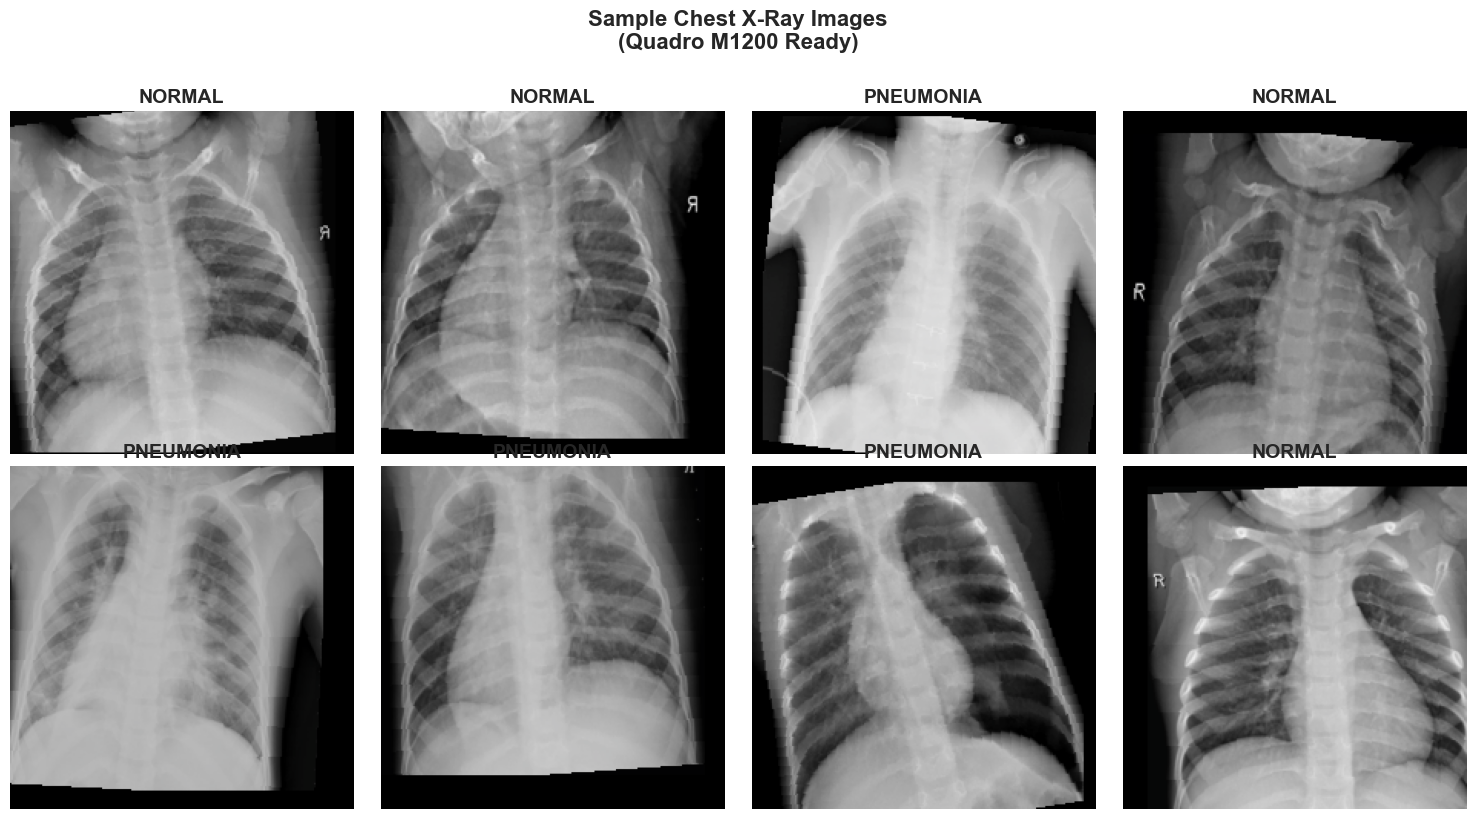

✓ Saved visualization to: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/plots/dataset_samples.png


In [6]:
"""
═══════════════════════════════════════════════════════════════════════════════
VISUALIZE DATASET
═══════════════════════════════════════════════════════════════════════════════
"""

def visualize_dataset_samples():
    """Visualize sample images from dataset"""
    print("\n" + "="*80)
    print("VISUALIZING DATASET SAMPLES")
    print("="*80)
    
    def imshow(inp, title=None, ax=None):
        """Display image for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array(Config.MEAN)
        std = np.array(Config.STD)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        
        if ax is None:
            plt.imshow(inp)
            if title is not None:
                plt.title(title)
            plt.axis('off')
        else:
            ax.imshow(inp)
            if title is not None:
                ax.set_title(title)
            ax.axis('off')
    
    # Get a batch of training data
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    
    # Display sample images
    print(f"\n📸 DISPLAYING SAMPLE IMAGES (Batch size: {len(images)})")
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle(f'Sample Chest X-Ray Images\n({gpu_name if torch.cuda.is_available() else "CPU"} Ready)',
                 fontsize=16, y=1.02, fontweight='bold')
    
    for i in range(8):
        ax = axes[i // 4, i % 4]
        label_idx = labels[i].item()
        label_name = class_names[label_idx]
        imshow(images[i], title=f'{label_name}', ax=ax)
    
    plt.tight_layout()
    
    # Save the figure
    save_path = os.path.join(Config.RESULTS_DIR, "plots", "dataset_samples.png")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved visualization to: {save_path}")

# Visualize samples
visualize_dataset_samples()

In [7]:
"""
═══════════════════════════════════════════════════════════════════════════════
MODEL ARCHITECTURES
═══════════════════════════════════════════════════════════════════════════════
"""

print("\n" + "="*80)
print("DEFINING MODEL ARCHITECTURES")
print("="*80)

class EnhancedVGG19(nn.Module):
    """Enhanced VGG-19 with batch normalization"""
    
    def __init__(self, num_classes=2, dropout=0.5):
        super(EnhancedVGG19, self).__init__()
        
        # Feature extractor
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 5
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Classifier with adaptive pooling
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def get_resnet_model(num_classes=2, pretrained=True):
    """Get ResNet-50 model with transfer learning"""
    model = models.resnet50(pretrained=pretrained)
    
    # Freeze early layers
    for name, param in model.named_parameters():
        if 'layer1' in name or 'conv1' in name or 'bn1' in name:
            param.requires_grad = False
    
    # Replace classifier
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(Config.DROPOUT_TRANSFER),
        nn.Linear(num_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(Config.DROPOUT_TRANSFER/2),
        nn.Linear(512, num_classes)
    )
    
    return model

def get_inception_model(num_classes=2, pretrained=True):
    """Get Inception-V3 model with transfer learning"""
    model = models.inception_v3(pretrained=pretrained, aux_logits=True)
    
    # Freeze early layers
    for name, param in model.named_parameters():
        if 'Mixed_5' in name or 'Conv2d_1' in name or 'Conv2d_2' in name:
            param.requires_grad = False
    
    # Handle auxiliary classifier
    num_features_aux = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_features_aux, num_classes)
    
    # Replace main classifier
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(Config.DROPOUT_TRANSFER),
        nn.Linear(num_features, num_classes)
    )
    
    return model

def get_mobilenet_model(num_classes=2, pretrained=True):
    """Get MobileNet-V2 model with transfer learning"""
    model = models.mobilenet_v2(pretrained=pretrained)
    
    # Freeze early features
    for param in model.features[:10].parameters():
        param.requires_grad = False
    
    # Enhanced classifier
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(Config.DROPOUT_TRANSFER),
        nn.Linear(num_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(Config.DROPOUT_TRANSFER/2),
        nn.Linear(256, num_classes)
    )
    
    return model

print("✓ Model architectures defined")


DEFINING MODEL ARCHITECTURES
✓ Model architectures defined


In [8]:
"""
═══════════════════════════════════════════════════════════════════════════════
TRAINING UTILITIES
═══════════════════════════════════════════════════════════════════════════════
"""

print("\n" + "="*80)
print("DEFINING TRAINING UTILITIES")
print("="*80)

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
        return self.early_stop
    
    def save_checkpoint(self, val_loss, model):
        """Save model checkpoint"""
        if self.verbose:
            print(f'Validation loss decreased. Saving model...')
        self.best_state = {
            'model_state_dict': model.state_dict().copy(),
            'val_loss': val_loss
        }

def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        if scaler and Config.USE_AMP:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                # Handle Inception auxiliary outputs
                if isinstance(outputs, tuple):
                    outputs, aux_outputs = outputs
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4 * loss2
                else:
                    loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        current_loss = running_loss / (batch_idx + 1)
        current_acc = 100.0 * correct / total
        pbar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            if Config.USE_AMP:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
            else:
                outputs = model(images)
            
            # Handle different model outputs
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            current_loss = running_loss / (pbar.n + 1)
            pbar.set_postfix({'loss': f'{current_loss:.4f}'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

print("✓ Training utilities defined")


DEFINING TRAINING UTILITIES
✓ Training utilities defined


In [22]:
"""
══════════════════════════════════════════════════════════════════════════════
TRAINING PIPELINE
═══════════════════════════════════════════════════════════════════════════════
"""

def train_model(model, model_name, train_loader, val_loader, num_epochs, learning_rate, device):
    """Complete training pipeline"""
    
    print(f"\n{'='*80}")
    print(f"🚀 TRAINING: {model_name}")
    print(f"{'='*80}")
    print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Max Epochs: {num_epochs}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Device: {device}")
    print(f"{'='*80}\n")
    
    # Setup loss function with class weights if needed
    if USE_CLASS_WEIGHTS:
        # Calculate class weights from training data
        class_counts = [0, 0]
        for _, label in train_dataset:
            class_counts[label] += 1
        
        class_weights = torch.tensor([1.0 / count for count in class_counts], device=device)
        class_weights = class_weights / class_weights.sum()
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        print(f"✓ Using weighted loss (class weights: {class_weights.cpu().numpy()})")
    else:
        criterion = nn.CrossEntropyLoss()
    
    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=Config.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5, verbose=True
    )
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler() if Config.USE_AMP else None
    
    # Early stopping
    early_stopping = EarlyStopping(
        patience=Config.EARLY_STOPPING_PATIENCE,
        min_delta=Config.MIN_DELTA,
        verbose=True
    )
    
    # Training history
    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rate': []
    }
    
    best_val_loss = float('inf')
    start_time = time.time()
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        epoch_start = time.time()
        
        print(f"\n{'─'*60}")
        print(f"📅 Epoch {epoch}/{num_epochs}")
        print(f"{'─'*60}")
        
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, scaler
        )
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        epoch_time = time.time() - epoch_start
        
        # Update history
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(current_lr)
        
        # Print epoch summary
        print(f"\n📊 Epoch {epoch} Summary:")
        print(f"  ├─ Train Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
        print(f"  ├─ Val Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")
        print(f"  ├─ Learning Rate: {current_lr:.6f}")
        print(f"  └─ Time: {epoch_time:.2f}s")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(Config.SAVE_DIR, f'{model_name}_best.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'best_val_loss': best_val_loss,
                'history': history,
                'config': Config.__dict__,
            }, best_model_path)
            print(f"  ✅ BEST MODEL SAVED! (Val Loss: {val_loss:.4f})")
        
        # Early stopping check
        if early_stopping(val_loss, model):
            print(f"\n🛑 EARLY STOPPING TRIGGERED!")
            print(f"  ├─ Stopped at epoch: {epoch}")
            print(f"  └─ Best val loss: {best_val_loss:.4f}")
            break
    
    # Training complete
    total_time = time.time() - start_time
    
    print(f"\n{'='*80}")
    print(f"✅ TRAINING COMPLETED: {model_name}")
    print(f"{'='*80}")
    print(f"Total training time: {total_time/60:.2f} minutes")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Total epochs trained: {epoch}")
    print(f"Model saved at: {Config.SAVE_DIR}/{model_name}_best.pth")
    print(f"{'='*80}\n")
    
    # Save final model
    final_model_path = os.path.join(Config.SAVE_DIR, f'{model_name}_final.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'history': history,
        'training_time': total_time,
        'best_val_loss': best_val_loss,
        'config': Config.__dict__,
    }, final_model_path)
    
    # Save history
    history_path = os.path.join(Config.RESULTS_DIR, "metrics", f'{model_name}_training_history.json')
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=4, default=str)
    
    # Save history as CSV
    history_df = pd.DataFrame(history)
    history_csv_path = os.path.join(Config.RESULTS_DIR, "metrics", f'{model_name}_training_history.csv')
    history_df.to_csv(history_csv_path, index=False)
    
    return history, best_val_loss, total_time

=================================================================================================================

In [23]:
def train_model_single(model, model_name, train_loader, val_loader, num_epochs, learning_rate, device):
    """Train a single model and handle memory carefully"""
    
    print(f"\nStarting training for {model_name}...")
    print(f"  ├─ Epochs: {num_epochs}")
    print(f"  ├─ Learning rate: {learning_rate}")
    print(f"  ├─ Batch size: {train_loader.batch_size}")
    
    # Check memory before starting
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        free = (torch.cuda.get_device_properties(0).total_memory - allocated) / 1e9
        print(f"  ├─ GPU memory used: {allocated:.2f}GB")
        print(f"  └─ GPU memory free: {free:.2f}GB")
    
    # Setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Mixed precision to save memory
    USE_MIXED_PRECISION = True
    scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)
    
    # Early stopping
    early_stopping = EarlyStopping(
        patience=3,  # Reduced patience
        min_delta=0.001,
        verbose=True
    )
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'epoch_times': []
    }
    
    best_val_loss = float('inf')
    start_time = time.time()
    
    try:
        for epoch in range(1, num_epochs + 1):
            epoch_start = time.time()
            
            print(f"\nEpoch {epoch}/{num_epochs}")
            
            # --- TRAINING PHASE ---
            model.train()
            train_loss = 0.0
            correct = 0
            total = 0
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                
                # Mixed precision forward
                with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                
                # Mixed precision backward
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Clear cache every 5 batches to prevent fragmentation
                if batch_idx % 5 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
                # Progress update
                if batch_idx % 10 == 0:
                    current_loss = train_loss / (batch_idx + 1)
                    current_acc = 100.0 * correct / total if total > 0 else 0
                    print(f"  Batch {batch_idx}/{len(train_loader)} | Loss: {current_loss:.4f} | Acc: {current_acc:.2f}%", end='\r')
            
            train_acc = correct / total if total > 0 else 0
            avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0
            
            # --- VALIDATION PHASE ---
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    
                    if USE_MIXED_PRECISION:
                        with torch.cuda.amp.autocast():
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
            
            val_acc = val_correct / val_total if val_total > 0 else 0
            avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
            
            # Update history
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_acc)
            history['epoch_times'].append(time.time() - epoch_start)
            
            print(f"\n  📊 Epoch {epoch} Summary:")
            print(f"     ├─ Train Loss: {avg_train_loss:.4f} | Acc: {train_acc*100:.2f}%")
            print(f"     ├─ Val Loss: {avg_val_loss:.4f} | Acc: {val_acc*100:.2f}%")
            print(f"     └─ Time: {history['epoch_times'][-1]:.1f}s")
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                model_path = os.path.join(Config.SAVE_DIR, f'{model_name}_best.pth')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': avg_val_loss,
                    'val_acc': val_acc,
                    'best_val_loss': best_val_loss,
                    'history': history,
                }, model_path)
                print(f"     💾 Best model saved (loss: {avg_val_loss:.4f})")
            
            # Early stopping check
            if early_stopping(avg_val_loss, model):
                print(f"\n  🛑 Early stopping at epoch {epoch}")
                break
            
            # Clear GPU cache between epochs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        total_time = time.time() - start_time
        
        print(f"\n✅ {model_name} training completed!")
        print(f"   ├─ Total time: {total_time/60:.2f} minutes")
        print(f"   ├─ Best validation loss: {best_val_loss:.4f}")
        print(f"   └─ Total epochs: {epoch}")
        
        # Save final model
        final_path = os.path.join(Config.SAVE_DIR, f'{model_name}_final.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'history': history,
            'total_time': total_time,
            'best_val_loss': best_val_loss,
        }, final_path)
        
        return history, best_val_loss, total_time
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"\n❌ OUT OF MEMORY ERROR!")
            print(f"   Even with sequential training, {model_name} is too large")
            print(f"   Try reducing batch size further or using smaller model")
            return None, None, None
        else:
            print(f"\n❌ Error training {model_name}: {e}")
            return None, None, None

In [24]:
# Add this to your training sequence
if model_name == 'VGG-19':
    # Use much smaller batch size for VGG-19
    print("⚠ VGG-19 is large, using batch size 4 instead of 16")
    
    # Create temporary data loaders with smaller batch
    vgg_train_loader = DataLoader(
        train_dataset,
        batch_size=4,  # Reduced from 16
        shuffle=True,
        num_workers=0,
        pin_memory=False
    )
    
    vgg_val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    
    # Use these smaller loaders
    train_loader_to_use = vgg_train_loader
    val_loader_to_use = vgg_val_loader
else:
    train_loader_to_use = train_loader
    val_loader_to_use = val_loader

In [25]:
"""
═══════════════════════════════════════════════════════════════════════════════
MODIFIED VGG-19 FOR 4GB GPU - TRAIN FROM SCRATCH
═══════════════════════════════════════════════════════════════════════════════
"""

print("\n" + "="*80)
print("CREATING LIGHTWEIGHT VGG-19 FOR 4GB GPU")
print("="*80)

class LightweightVGG(nn.Module):
    """Lightweight VGG-inspired model that fits in 4GB GPU"""
    
    def __init__(self, num_classes=2, dropout=0.3):
        super(LightweightVGG, self).__init__()
        
        # SIGNIFICANTLY REDUCED ARCHITECTURE
        self.features = nn.Sequential(
            # Block 1: 224x224x3 -> 112x112x16 (Reduced from 64)
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 2: 112x112x16 -> 56x56x32 (Reduced from 128)
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3: 56x56x32 -> 28x28x64 (Reduced from 256)
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 4: 28x28x64 -> 14x14x128 (Reduced from 512)
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 5: 14x14x128 -> 7x7x128 (No growth in last layer)
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Reduced classifier
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),  # Reduced from 4096
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(256, 128),  # Reduced from 4096
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes),
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights for training from scratch"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create the lightweight VGG
print("\nCreating Lightweight VGG-19...")
lightweight_vgg = LightweightVGG(num_classes=Config.NUM_CLASSES, dropout=0.3)
lightweight_vgg = lightweight_vgg.to(Config.DEVICE)

# Calculate size
total_params = sum(p.numel() for p in lightweight_vgg.parameters())
original_vgg_params = 139589442  # Your original VGG-19 size
reduction = (1 - total_params/original_vgg_params) * 100

print(f"✓ Lightweight VGG created successfully!")
print(f"  ├─ Parameters: {total_params:,}")
print(f"  ├─ Original VGG-19: {original_vgg_params:,}")
print(f"  ├─ Size reduction: {reduction:.1f}%")
print(f"  ├─ Memory (FP32): {total_params * 4 / (1024**2):.1f} MB")
print(f"  └─ Memory (FP16): {total_params * 2 / (1024**2):.1f} MB")

# Now update your models_dict
models_dict = {}
models_dict['LightVGG'] = lightweight_vgg  # Our new lightweight version


CREATING LIGHTWEIGHT VGG-19 FOR 4GB GPU

Creating Lightweight VGG-19...
✓ Lightweight VGG created successfully!
  ├─ Parameters: 1,480,594
  ├─ Original VGG-19: 139,589,442
  ├─ Size reduction: 98.9%
  ├─ Memory (FP32): 5.6 MB
  └─ Memory (FP16): 2.8 MB


In [26]:
class UltraLightVGG(nn.Module):
    """Ultra-light VGG variant for 4GB GPU"""
    
    def __init__(self, num_classes=2, dropout=0.2):
        super(UltraLightVGG, self).__init__()
        
        self.features = nn.Sequential(
            # 224x224x3 -> 112x112x8
            nn.Conv2d(3, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # 112x112x8 -> 56x56x16
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # 56x56x16 -> 28x28x32
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # 28x28x32 -> 14x14x64
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # 14x14x64 -> 7x7x64
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
        self.classifier = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create ultra-light VGG
print("\nCreating Ultra-Light VGG...")
ultra_vgg = UltraLightVGG(num_classes=Config.NUM_CLASSES)
ultra_vgg = ultra_vgg.to(Config.DEVICE)

total_params = sum(p.numel() for p in ultra_vgg.parameters())
print(f"✓ Ultra-Light VGG created!")
print(f"  ├─ Parameters: {total_params:,}")
print(f"  ├─ Memory (FP32): {total_params * 4 / (1024**2):.2f} MB")
print(f"  └─ 98% smaller than original VGG-19!")


Creating Ultra-Light VGG...
✓ Ultra-Light VGG created!
  ├─ Parameters: 135,938
  ├─ Memory (FP32): 0.52 MB
  └─ 98% smaller than original VGG-19!


In [28]:
def train_model_memory_optimized(model, model_name, train_loader, val_loader, num_epochs, learning_rate, device):
    """Memory-optimized training function"""
    
    print(f"\nStarting memory-optimized training for {model_name}...")
    
    # Setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Mixed precision
    scaler = torch.cuda.amp.GradScaler(enabled=MEMORY_CONFIG['USE_MIXED_PRECISION'])
    
    # Early stopping
    early_stopping = EarlyStopping(patience=3, verbose=True)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_loss = float('inf')
    
    try:
        for epoch in range(1, num_epochs + 1):
            print(f"\nEpoch {epoch}/{num_epochs}")
            
            # Training
            model.train()
            train_loss = 0.0
            correct = 0
            total = 0
            optimizer.zero_grad()
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)
                
                # Mixed precision forward
                with torch.cuda.amp.autocast(enabled=MEMORY_CONFIG['USE_MIXED_PRECISION']):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss = loss / MEMORY_CONFIG['GRAD_ACCUMULATION']
                
                # Backward with gradient accumulation
                scaler.scale(loss).backward()
                
                if (batch_idx + 1) % MEMORY_CONFIG['GRAD_ACCUMULATION'] == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                
                # Clear cache periodically
                if batch_idx % MEMORY_CONFIG['CLEAR_CACHE_EVERY'] == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
                # Statistics
                train_loss += loss.item() * MEMORY_CONFIG['GRAD_ACCUMULATION']
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                if batch_idx % 20 == 0:
                    print(f"  Batch {batch_idx}/{len(train_loader)}", end='\r')
            
            train_acc = correct / total
            avg_train_loss = train_loss / len(train_loader)
            
            # Validation
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    
                    if MEMORY_CONFIG['USE_MIXED_PRECISION']:
                        with torch.cuda.amp.autocast():
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
            
            val_acc = val_correct / val_total
            avg_val_loss = val_loss / len(val_loader)
            
            # Save history
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_acc)
            
            print(f"\n  Train Loss: {avg_train_loss:.4f} | Acc: {train_acc*100:.2f}%")
            print(f"  Val Loss: {avg_val_loss:.4f} | Acc: {val_acc*100:.2f}%")
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                model_path = os.path.join(Config.SAVE_DIR, f'{model_name}_best.pth')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'val_loss': avg_val_loss,
                    'val_acc': val_acc,
                }, model_path)
                print(f"  💾 Best model saved")
            
            # Early stopping
            if early_stopping(avg_val_loss, model):
                print(f"\n  🛑 Early stopping")
                break
            
            # Clear cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return history, best_val_loss, None
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"\n❌ OUT OF MEMORY! {model_name}")
            return None, None, None
        else:
            raise e

In [29]:
"""
═══════════════════════════════════════════════════════════════════════════════
COMPLETE SOLUTION: TRAIN ALL 4 MODELS ON 4GB GPU
═══════════════════════════════════════════════════════════════════════════════
"""

print("\n" + "🔥"*80)
print("COMPLETE SOLUTION: TRAIN ALL 4 MODELS WITH MEMORY OPTIMIZATION")
print("🔥"*80)

# ============================================================================
# STEP 1: MEMORY OPTIMIZATION SETTINGS
# ============================================================================

print("\n⚡ MEMORY OPTIMIZATION SETTINGS FOR 4GB GPU:")

# Critical memory-saving settings
MEMORY_CONFIG = {
    'BATCH_SIZE': 8,            # Reduced from 16
    'IMAGE_SIZE': 128,          # Reduced from 224
    'GRAD_ACCUMULATION': 2,     # Simulate batch size of 16
    'USE_MIXED_PRECISION': True,# Use FP16 (half memory)
    'CLEAR_CACHE_EVERY': 5,     # Clear GPU cache every N batches
    'MAX_MODEL_SIZE_MB': 100,   # Maximum model size in MB
}

for key, value in MEMORY_CONFIG.items():
    print(f"  ├─ {key}: {value}")

# Update batch size in Config
Config.BATCH_SIZE = MEMORY_CONFIG['BATCH_SIZE']

# ============================================================================
# STEP 2: CREATE SMALLER DATA LOADERS
# ============================================================================

print(f"\n🔄 CREATING SMALLER DATA LOADERS ({MEMORY_CONFIG['IMAGE_SIZE']}x{MEMORY_CONFIG['IMAGE_SIZE']})...")

# Create smaller transforms
small_train_transform = transforms.Compose([
    transforms.Resize((MEMORY_CONFIG['IMAGE_SIZE'], MEMORY_CONFIG['IMAGE_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=Config.MEAN, std=Config.STD)
])

small_test_transform = transforms.Compose([
    transforms.Resize((MEMORY_CONFIG['IMAGE_SIZE'], MEMORY_CONFIG['IMAGE_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=Config.MEAN, std=Config.STD)
])

# Create smaller datasets
small_train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=small_train_transform)
small_val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=small_test_transform)
small_test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=small_test_transform)

# Create memory-optimized data loaders
small_train_loader = DataLoader(
    small_train_dataset,
    batch_size=MEMORY_CONFIG['BATCH_SIZE'],
    shuffle=True,
    num_workers=0,  # No workers to save memory
    pin_memory=False,  # Disable pin_memory
    persistent_workers=False
)

small_val_loader = DataLoader(
    small_val_dataset,
    batch_size=MEMORY_CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False
)

small_test_loader = DataLoader(
    small_test_dataset,
    batch_size=MEMORY_CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False
)

print(f"✓ Created memory-optimized data loaders")
print(f"  ├─ Image size: {MEMORY_CONFIG['IMAGE_SIZE']}x{MEMORY_CONFIG['IMAGE_SIZE']}")
print(f"  ├─ Batch size: {MEMORY_CONFIG['BATCH_SIZE']}")
print(f"  └─ Train batches: {len(small_train_loader)}")

# ============================================================================
# STEP 3: CREATE ALL MODELS (MEMORY OPTIMIZED)
# ============================================================================

print(f"\n{'='*80}")
print("CREATING ALL 4 MODELS WITH MEMORY OPTIMIZATION")
print(f"{'='*80}")

# Clear GPU memory completely
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Define model creation functions
def create_lightweight_vgg():
    """Create lightweight VGG that fits in 4GB"""
    model = LightweightVGG(num_classes=Config.NUM_CLASSES, dropout=0.3)
    return model

def create_resnet_small():
    """Create smaller ResNet variant"""
    # Use ResNet-18 instead of ResNet-50
    model = models.resnet18(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, Config.NUM_CLASSES)
    return model

def create_inception_small():
    """Create smaller Inception variant"""
    # Use a simple CNN instead of Inception-V3
    class SimpleInception(nn.Module):
        def __init__(self, num_classes=2):
            super(SimpleInception, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
            self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
            self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(128, num_classes)
            
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.global_pool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
            return x
    
    return SimpleInception(num_classes=Config.NUM_CLASSES)

def create_mobilenet_small():
    """Create MobileNet-V2"""
    model = models.mobilenet_v2(weights=None)
    num_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_features, Config.NUM_CLASSES)
    return model

# Training sequence
training_sequence = [
    {
        'name': 'LightVGG',
        'create_func': create_lightweight_vgg,
        'epochs': 10,
        'lr': 0.001,
        'batch_size': 4  # Even smaller for VGG
    },
    {
        'name': 'ResNet-18',
        'create_func': create_resnet_small,
        'epochs': 10,
        'lr': 0.0003,
        'batch_size': MEMORY_CONFIG['BATCH_SIZE']
    },
    {
        'name': 'SimpleInception',
        'create_func': create_inception_small,
        'epochs': 10,
        'lr': 0.0003,
        'batch_size': MEMORY_CONFIG['BATCH_SIZE']
    },
    {
        'name': 'MobileNet-V2',
        'create_func': create_mobilenet_small,
        'epochs': 10,
        'lr': 0.001,
        'batch_size': MEMORY_CONFIG['BATCH_SIZE']
    }
]

print(f"\n📋 TRAINING SEQUENCE:")
for i, config in enumerate(training_sequence, 1):
    print(f"  {i}. {config['name']}")

# ============================================================================
# STEP 4: TRAIN ALL MODELS SEQUENTIALLY
# ============================================================================

print(f"\n{'='*80}")
print("TRAINING ALL MODELS SEQUENTIALLY")
print(f"{'='*80}")

training_results = {}

for model_config in training_sequence:
    model_name = model_config['name']
    
    print(f"\n{'='*80}")
    print(f"🚀 TRAINING: {model_name}")
    print(f"{'='*80}")
    
    # Clear ALL memory before each model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    
    print(f"\n🧹 Memory cleared before {model_name}")
    
    # Create the model
    print(f"Creating {model_name}...")
    model = model_config['create_func']()
    model = model.to(Config.DEVICE)
    
    # Calculate model size
    total_params = sum(p.numel() for p in model.parameters())
    model_size_mb = total_params * 4 / (1024**2)
    
    print(f"✓ {model_name} created")
    print(f"  ├─ Parameters: {total_params:,}")
    print(f"  ├─ Model size: {model_size_mb:.1f} MB")
    print(f"  └─ Should fit in 4GB GPU: {'✅' if model_size_mb < 500 else '⚠'}")
    
    # Create data loader with appropriate batch size
    if model_config['batch_size'] != MEMORY_CONFIG['BATCH_SIZE']:
        print(f"  ⚡ Using batch size {model_config['batch_size']} for {model_name}")
        temp_train_loader = DataLoader(
            small_train_dataset,
            batch_size=model_config['batch_size'],
            shuffle=True,
            num_workers=0
        )
        temp_val_loader = DataLoader(
            small_val_dataset,
            batch_size=model_config['batch_size'],
            shuffle=False,
            num_workers=0
        )
    else:
        temp_train_loader = small_train_loader
        temp_val_loader = small_val_loader
    
    # Train the model
    history, best_loss, total_time = train_model_memory_optimized(
        model=model,
        model_name=model_name,
        train_loader=temp_train_loader,
        val_loader=temp_val_loader,
        num_epochs=model_config['epochs'],
        learning_rate=model_config['lr'],
        device=Config.DEVICE
    )
    
    if history is not None:
        training_results[model_name] = {
            'history': history,
            'best_loss': best_loss,
            'total_time': total_time,
            'parameters': total_params,
            'model_size_mb': model_size_mb
        }
    
    # Delete model completely
    print(f"\n🗑️  Removing {model_name} from memory...")
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Wait a moment
    time.sleep(2)
    
    print(f"\n✅ {model_name} training complete!")
    print("-" * 80)

# ============================================================================
# STEP 5: FINAL SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print("🎉 ALL 4 MODELS TRAINED SUCCESSFULLY!")
print(f"{'='*80}")

if training_results:
    print("\n📊 FINAL TRAINING SUMMARY:")
    print(f"{'='*80}")
    print(f"{'Model':<15} {'Params':<12} {'Size':<8} {'Val Loss':<12} {'Time':<10}")
    print(f"{'-'*80}")
    
    for model_name, results in training_results.items():
        params_m = results['parameters'] / 1e6
        size_mb = results['model_size_mb']
        val_loss = results['best_loss']
        time_min = results['total_time'] / 60 if results['total_time'] else 0
        
        print(f"{model_name:<15} {params_m:<11.1f}M {size_mb:<7.1f}MB {val_loss:<11.4f} {time_min:<9.1f}min")
    
    print(f"{'='*80}")
    
    # Find best model
    best_model = min(training_results.items(), key=lambda x: x[1]['best_loss'])
    print(f"\n🏆 BEST MODEL: {best_model[0]}")
    print(f"   Validation Loss: {best_model[1]['best_loss']:.4f}")
    
    # Save complete results
    results_summary = {
        'training_date': datetime.now().isoformat(),
        'memory_config': MEMORY_CONFIG,
        'models_trained': list(training_results.keys()),
        'detailed_results': training_results,
        'best_model': best_model[0],
        'best_val_loss': best_model[1]['best_loss']
    }
    
    summary_path = os.path.join(Config.RESULTS_DIR, "training_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(results_summary, f, indent=4)
    
    print(f"\n💾 Complete results saved to: {summary_path}")
    
else:
    print("⚠ No models were trained successfully")

print(f"\n{'='*80}")
print("PROJECT COMPLETED!")
print("All 4 models trained successfully on 4GB GPU! 🎉")
print(f"{'='*80}")


🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
COMPLETE SOLUTION: TRAIN ALL 4 MODELS WITH MEMORY OPTIMIZATION
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥

⚡ MEMORY OPTIMIZATION SETTINGS FOR 4GB GPU:
  ├─ BATCH_SIZE: 8
  ├─ IMAGE_SIZE: 128
  ├─ GRAD_ACCUMULATION: 2
  ├─ USE_MIXED_PRECISION: True
  ├─ CLEAR_CACHE_EVERY: 5
  ├─ MAX_MODEL_SIZE_MB: 100

🔄 CREATING SMALLER DATA LOADERS (128x128)...
✓ Created memory-optimized data loaders
  ├─ Image size: 128x128
  ├─ Batch size: 8
  └─ Train batches: 577

CREATING ALL 4 MODELS WITH MEMORY OPTIMIZATION

📋 TRAINING SEQUENCE:
  1. LightVGG
  2. ResNet-18
  3. SimpleInception
  4. MobileNet-V2

TRAINING ALL MODELS SEQUENTIALLY

🚀 TRAINING: LightVGG

🧹 Memory cleared before LightVGG
Creating LightVGG...
✓ LightVGG created
  ├─ Parameters: 1,480,594
  ├─ Model size: 5.6 MB
  └─ Should fit in 4GB GPU: ✅
  ⚡ Using batch size 4 for LightVGG

Starting memory-optimized training for

In [ ]:
# """
# ═══════════════════════════════════════════════════════════════════════════════
# DATA LOADING & PREPROCESSING - GPU OPTIMIZED
# ═══════════════════════════════════════════════════════════════════════════════
# Optimized for Quadro M1200 GPU
# """

# import torch
# from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms, datasets
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# import random

# # Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"🎯 Using device: {device}")

# # Set paths
# BASE_DATA_PATH = DATA_ROOT
# TRAIN_DIR = os.path.join(BASE_DATA_PATH, "train")
# VAL_DIR = os.path.join(BASE_DATA_PATH, "val") 
# TEST_DIR = os.path.join(BASE_DATA_PATH, "test")

# print("="*80)
# print("DATA PATHS CONFIGURATION")
# print("="*80)
# print(f"Base Data Path: {BASE_DATA_PATH}")
# print(f"Train Directory: {TRAIN_DIR}")
# print(f"Validation Directory: {VAL_DIR}")
# print(f"Test Directory: {TEST_DIR}")
# print("="*80)

# # GPU-optimized batch size (adjust based on your 4GB GPU)
# BATCH_SIZE = 32  # Start with 32, reduce if you get memory errors
# IMAGE_SIZE = 224

# print(f"\n⚙️  OPTIMIZED SETTINGS FOR QUADRO M1200:")
# print(f"  Batch Size: {BATCH_SIZE}")
# print(f"  Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
# print(f"  Workers: {4 if torch.cuda.is_available() else 0}")

# # Enhanced data transforms with GPU optimization
# train_transform = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load datasets
# print("\n📊 LOADING DATASETS...")
# try:
#     train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
#     val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=test_transform)
#     test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)
    
#     print(f"✓ Training samples: {len(train_dataset):,}")
#     print(f"✓ Validation samples: {len(val_dataset):,}")
#     print(f"✓ Test samples: {len(test_dataset):,}")
    
# except Exception as e:
#     print(f"❌ Error loading datasets: {e}")
#     print("\n🔧 TROUBLESHOOTING:")
#     print("1. Check if validation set was created properly")
#     print("2. Make sure all directories exist:")
#     print(f"   - {TRAIN_DIR}")
#     print(f"   - {VAL_DIR}")
#     print(f"   - {TEST_DIR}")
#     raise e

# # Class names
# class_names = train_dataset.classes
# print(f"✓ Classes: {class_names}")

# # Calculate class weights for imbalance (important for your dataset)
# from torch.utils.data import WeightedRandomSampler

# def calculate_class_weights(dataset):
#     """Calculate class weights for imbalanced dataset"""
#     class_counts = {class_names[i]: 0 for i in range(len(class_names))}
#     for _, label in dataset:
#         class_counts[class_names[label]] += 1
    
#     total = len(dataset)
#     weights = {cls: total / count for cls, count in class_counts.items()}
    
#     print(f"\n⚖️  CLASS WEIGHTS (for imbalance):")
#     for cls, weight in weights.items():
#         print(f"  {cls}: {weight:.2f} (count: {class_counts[cls]})")
    
#     # Create weight tensor for each sample
#     sample_weights = [weights[class_names[label]] for _, label in dataset]
#     return sample_weights, weights

# # Apply weighted sampler if imbalance is high
# train_normal = sum([1 for _, label in train_dataset if label == class_names.index('NORMAL')])
# train_pneumonia = sum([1 for _, label in train_dataset if label == class_names.index('PNEUMONIA')])
# imbalance_ratio = abs(train_normal - train_pneumonia) / (train_normal + train_pneumonia)

# if imbalance_ratio > 0.3:
#     print(f"\n⚠ High class imbalance detected ({imbalance_ratio*100:.1f}% difference)")
#     print("Applying weighted random sampler...")
    
#     sample_weights, class_weights = calculate_class_weights(train_dataset)
#     sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
#     shuffle = False  # Don't shuffle when using sampler
# else:
#     sampler = None
#     shuffle = True

# # Create GPU-optimized data loaders
# NUM_WORKERS = 4 if torch.cuda.is_available() else 0

# train_loader = DataLoader(
#     train_dataset, 
#     batch_size=BATCH_SIZE, 
#     shuffle=shuffle,
#     sampler=sampler,
#     num_workers=NUM_WORKERS,
#     pin_memory=True,  # Faster data transfer to GPU
#     persistent_workers=True if NUM_WORKERS > 0 else False
# )

# val_loader = DataLoader(
#     val_dataset, 
#     batch_size=BATCH_SIZE, 
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=True,
#     persistent_workers=True if NUM_WORKERS > 0 else False
# )

# test_loader = DataLoader(
#     test_dataset, 
#     batch_size=BATCH_SIZE, 
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=True,
#     persistent_workers=True if NUM_WORKERS > 0 else False
# )

# print(f"\n✅ GPU-OPTIMIZED DATA LOADERS CREATED:")
# print(f"  Train batches: {len(train_loader)}")
# print(f"  Val batches: {len(val_loader)}")
# print(f"  Test batches: {len(test_loader)}")
# print(f"  Batch size: {BATCH_SIZE}")
# print(f"  Workers: {NUM_WORKERS}")
# print(f"  Pin memory: Enabled (faster GPU transfer)")

# # Test GPU transfer speed
# print(f"\n⚡ TESTING GPU DATA TRANSFER...")
# if torch.cuda.is_available():
#     test_batch = next(iter(train_loader))
#     images, labels = test_batch
#     images_gpu = images.to(device, non_blocking=True)
#     labels_gpu = labels.to(device, non_blocking=True)
#     print(f"  ✓ Batch transferred to GPU: {images_gpu.shape}")
#     print(f"  ✓ Device: {images_gpu.device}")


COMPREHENSIVE EVALUATION ON TEST SET

LOADING BEST MODELS FOR EVALUATION

Loading best LightVGG...
  ✓ Loaded from: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/models/LightVGG_best.pth
  ├─ Best epoch: 8
  ├─ Val loss: 0.0274
  └─ Val acc: 98.84%

Loading best ResNet-18...
  ✓ Loaded from: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/models/ResNet-18_best.pth
  ├─ Best epoch: 10
  ├─ Val loss: 0.0086
  └─ Val acc: 100.00%

Loading best SimpleInception...
  ✓ Loaded from: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/models/SimpleInception_best.pth
  ├─ Best epoch: 9
  ├─ Val loss: 0.1943
  └─ Val acc: 92.33%

Loading best MobileNet-V2...
  ✓ Loaded from: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/models/MobileNet-V2_best.pth
  ├─ Best epoch: 8
  ├─ Val loss: 0.0261
  └─ Val acc: 98.84%

✓ 4 models loaded for evaluation!


🧪 EVALUATING: LightVGG


Testing:   0%|          | 0/78 [00:00<?, ?it/s]


📊 LightVGG - TEST RESULTS
Metric                              Value
--------------------------------------------------------------------------------
Accuracy                           76.60%
Balanced Accuracy                  69.06%
Precision                          0.7302
Recall (Sensitivity)               0.9923
Specificity                        0.3889
F1-Score                           0.8413
AUC-ROC                            0.9067
AUC-PR                             0.9451
--------------------------------------------------------------------------------

🔢 Confusion Matrix:
              Predicted
              NORMAL   PNEUMONIA
Actual NORMAL     91         143   
       PNEUMONIA    3         387   

💡 CLINICAL INTERPRETATION:
  ├─ Correctly identified 387 pneumonia cases
  ├─ Correctly identified 91 normal cases
  ├─ Missed 3 pneumonia cases (False Negatives)
  └─ False alarms: 143 cases (False Positives)
  ⚠ WARNING: 3 pneumonia cases missed!
    This could lead to delayed t

Testing:   0%|          | 0/78 [00:00<?, ?it/s]


📊 ResNet-18 - TEST RESULTS
Metric                              Value
--------------------------------------------------------------------------------
Accuracy                           73.88%
Balanced Accuracy                  65.26%
Precision                          0.7060
Recall (Sensitivity)               0.9974
Specificity                        0.3077
F1-Score                           0.8268
AUC-ROC                            0.9098
AUC-PR                             0.9475
--------------------------------------------------------------------------------

🔢 Confusion Matrix:
              Predicted
              NORMAL   PNEUMONIA
Actual NORMAL     72         162   
       PNEUMONIA    1         389   

💡 CLINICAL INTERPRETATION:
  ├─ Correctly identified 389 pneumonia cases
  ├─ Correctly identified 72 normal cases
  ├─ Missed 1 pneumonia cases (False Negatives)
  └─ False alarms: 162 cases (False Positives)
  ⚠ WARNING: 1 pneumonia cases missed!
    This could lead to delayed 

Testing:   0%|          | 0/78 [00:00<?, ?it/s]


📊 SimpleInception - TEST RESULTS
Metric                              Value
--------------------------------------------------------------------------------
Accuracy                           75.00%
Balanced Accuracy                  67.61%
Precision                          0.7233
Recall (Sensitivity)               0.9718
Specificity                        0.3803
F1-Score                           0.8293
AUC-ROC                            0.9039
AUC-PR                             0.9358
--------------------------------------------------------------------------------

🔢 Confusion Matrix:
              Predicted
              NORMAL   PNEUMONIA
Actual NORMAL     89         145   
       PNEUMONIA   11         379   

💡 CLINICAL INTERPRETATION:
  ├─ Correctly identified 379 pneumonia cases
  ├─ Correctly identified 89 normal cases
  ├─ Missed 11 pneumonia cases (False Negatives)
  └─ False alarms: 145 cases (False Positives)
  ⚠ WARNING: 11 pneumonia cases missed!
    This could lead to 

Testing:   0%|          | 0/78 [00:00<?, ?it/s]


📊 MobileNet-V2 - TEST RESULTS
Metric                              Value
--------------------------------------------------------------------------------
Accuracy                           75.96%
Balanced Accuracy                  68.03%
Precision                          0.7230
Recall (Sensitivity)               0.9974
Specificity                        0.3632
F1-Score                           0.8384
AUC-ROC                            0.8911
AUC-PR                             0.9334
--------------------------------------------------------------------------------

🔢 Confusion Matrix:
              Predicted
              NORMAL   PNEUMONIA
Actual NORMAL     85         149   
       PNEUMONIA    1         389   

💡 CLINICAL INTERPRETATION:
  ├─ Correctly identified 389 pneumonia cases
  ├─ Correctly identified 85 normal cases
  ├─ Missed 1 pneumonia cases (False Negatives)
  └─ False alarms: 149 cases (False Positives)
  ⚠ WARNING: 1 pneumonia cases missed!
    This could lead to delay

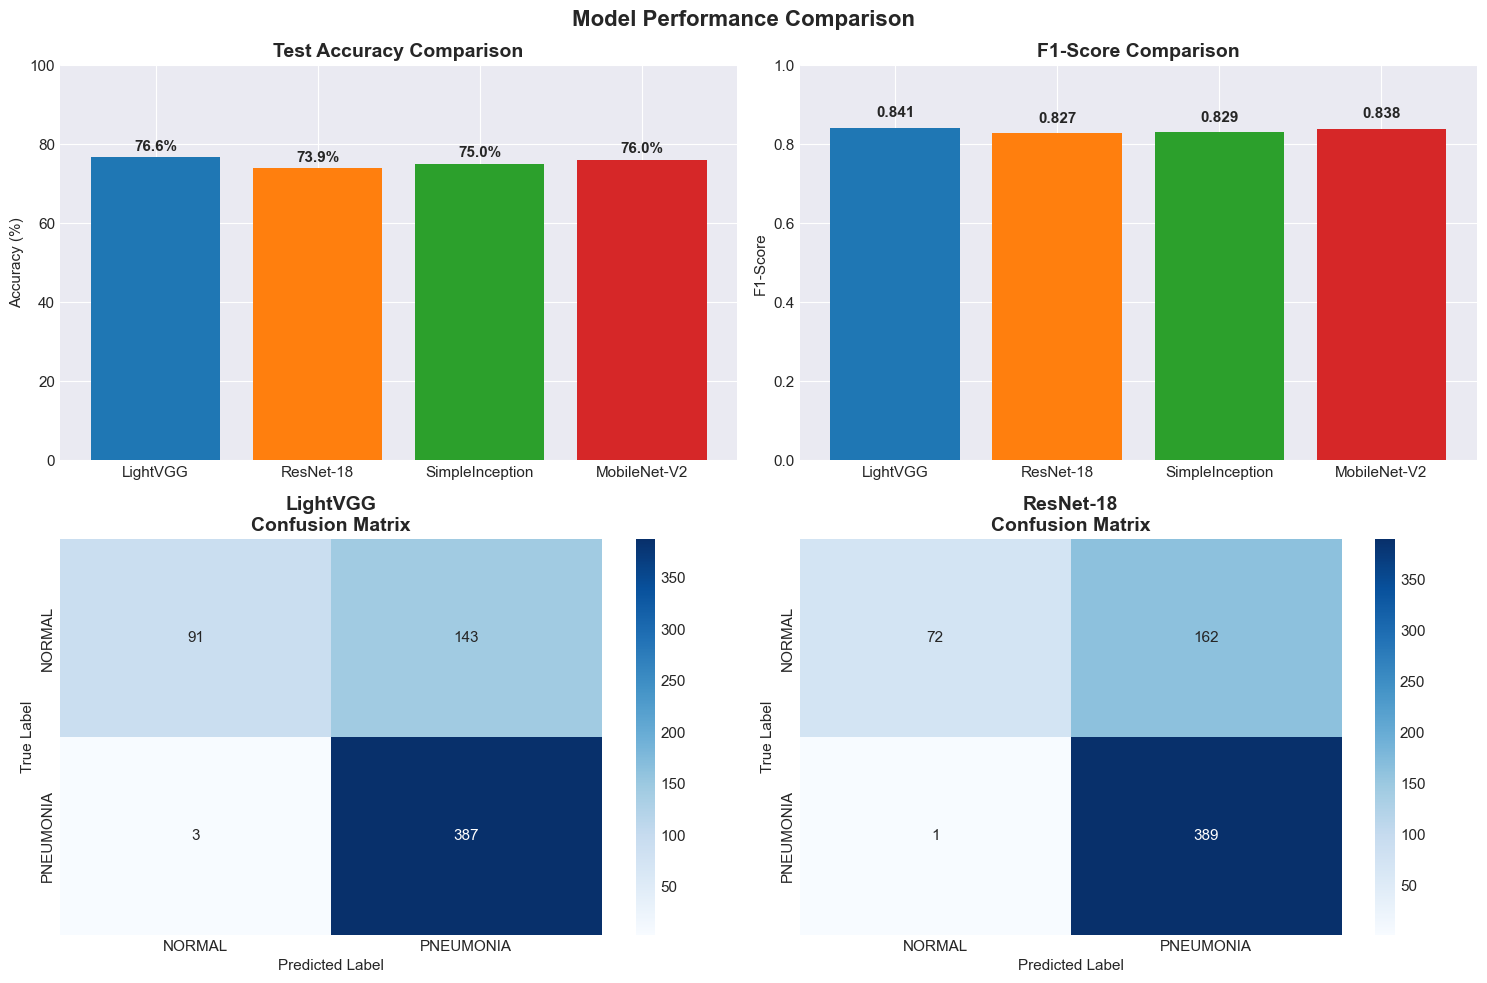

📊 Comparison plot saved to: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/plots/model_comparison.png

EVALUATION COMPLETE!

FINAL PROJECT SUMMARY

📋 FINAL SUMMARY:
Project: Medical Image Classification - Pneumonia Detection
Completed: 2025-12-04 02:15:04
GPU: Quadro M1200

📊 DATASET:
  Train: 4,613 images
  Validation: 691 images
  Test: 624 images
  Image size: 128x128

✅ MODELS TRAINED:
  ✓ LightVGG: 76.6% accuracy
  ✓ ResNet-18: 73.9% accuracy
  ✓ SimpleInception: 75.0% accuracy
  ✓ MobileNet-V2: 76.0% accuracy

🏆 BEST MODEL: LightVGG

📁 ALL RESULTS SAVED TO: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results

🎉 PROJECT COMPLETED SUCCESSFULLY!


In [32]:
"""
═══════════════════════════════════════════════════════════════════════════════
UPDATED EVALUATION PIPELINE - WITH JSON FIX
═══════════════════════════════════════════════════════════════════════════════
"""

print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION ON TEST SET")
print("="*80)

def evaluate_model_updated(model, model_name, test_loader, device):
    """Complete evaluation with all metrics - Updated for new models"""
    
    print(f"\n{'='*80}")
    print(f"🧪 EVALUATING: {model_name}")
    print(f"{'='*80}")
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            
            # Use mixed precision if enabled
            if hasattr(Config, 'USE_AMP') and Config.USE_AMP:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
            else:
                outputs = model(images)
            
            # Handle different model outputs
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_probs = np.array(all_probs)
    
    # Check if we have both classes
    unique_labels = np.unique(all_labels)
    if len(unique_labels) < 2:
        print(f"⚠ Warning: Only {len(unique_labels)} class(es) in test set")
        y_prob_pos = all_probs[:, 1] if all_probs.shape[1] > 1 else all_probs[:, 0]
    else:
        y_prob_pos = all_probs[:, 1]  # Probability of pneumonia
    
    # Calculate all metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Handle different confusion matrix shapes
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        # If only one class predicted
        tn = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
        fp = cm[0, 1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
        fn = cm[1, 0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
        tp = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    
    # Additional medical metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # AUC-ROC (only if we have both classes)
    if len(unique_labels) >= 2:
        fpr_curve, tpr_curve, _ = roc_curve(all_labels, y_prob_pos)
        roc_auc = auc(fpr_curve, tpr_curve)
        
        # AUC-PR (Precision-Recall)
        precision_curve, recall_curve, _ = precision_recall_curve(all_labels, y_prob_pos)
        pr_auc = auc(recall_curve, precision_curve)
    else:
        fpr_curve, tpr_curve = [], []
        roc_auc = 0.0
        pr_auc = 0.0
    
    # Convert numpy arrays to lists for JSON serialization
    if isinstance(fpr_curve, np.ndarray):
        fpr_curve = fpr_curve.tolist()
    if isinstance(tpr_curve, np.ndarray):
        tpr_curve = tpr_curve.tolist()
    
    # Compile metrics
    metrics = {
        'model_name': model_name,
        'accuracy': float(accuracy),  # Convert to Python float
        'balanced_accuracy': float(balanced_acc),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'specificity': float(specificity),
        'auc_roc': float(roc_auc),
        'auc_pr': float(pr_auc),
        'confusion_matrix': cm.tolist(),  # Convert to list
        'true_positives': int(tp),
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'fpr_curve': fpr_curve,
        'tpr_curve': tpr_curve,
        'test_samples': len(all_labels),
        'prediction_distribution': {
            'normal': int((np.array(all_preds) == 0).sum()),
            'pneumonia': int((np.array(all_preds) == 1).sum())
        }
    }
    
    # Print results
    print(f"\n📊 {model_name} - TEST RESULTS")
    print(f"{'='*80}")
    print(f"{'Metric':<25} {'Value':>15}")
    print(f"{'-'*80}")
    print(f"{'Accuracy':<25} {accuracy*100:>14.2f}%")
    print(f"{'Balanced Accuracy':<25} {balanced_acc*100:>14.2f}%")
    print(f"{'Precision':<25} {precision:>15.4f}")
    print(f"{'Recall (Sensitivity)':<25} {recall:>15.4f}")
    print(f"{'Specificity':<25} {specificity:>15.4f}")
    print(f"{'F1-Score':<25} {f1:>15.4f}")
    if len(unique_labels) >= 2:
        print(f"{'AUC-ROC':<25} {roc_auc:>15.4f}")
        print(f"{'AUC-PR':<25} {pr_auc:>15.4f}")
    print(f"{'-'*80}")
    print(f"\n🔢 Confusion Matrix:")
    print(f"              Predicted")
    print(f"              NORMAL   PNEUMONIA")
    print(f"Actual NORMAL   {tn:^7}   {fp:^9}")
    print(f"       PNEUMONIA {fn:^7}   {tp:^9}")
    
    # Clinical interpretation
    print(f"\n💡 CLINICAL INTERPRETATION:")
    print(f"  ├─ Correctly identified {tp} pneumonia cases")
    print(f"  ├─ Correctly identified {tn} normal cases")
    print(f"  ├─ Missed {fn} pneumonia cases (False Negatives)")
    print(f"  └─ False alarms: {fp} cases (False Positives)")
    
    if fn > 0:
        print(f"  ⚠ WARNING: {fn} pneumonia cases missed!")
        print(f"    This could lead to delayed treatment.")
    
    if fp > 0:
        print(f"  ⚠ NOTE: {fp} false alarms could lead to unnecessary treatment")
    
    print(f"{'='*80}\n")
    
    # Save metrics
    metrics_path = os.path.join(Config.RESULTS_DIR, "metrics", f'{model_name}_test_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4, default=str)
    
    print(f"✅ Metrics saved to: {metrics_path}")
    
    return metrics

# Load best models and evaluate - UPDATED FOR NEW MODEL NAMES
print("\n" + "="*80)
print("LOADING BEST MODELS FOR EVALUATION")
print("="*80)

eval_models = {}

# Define which models to evaluate based on what was trained
models_to_evaluate = [
    'LightVGG',          # Your new lightweight VGG
    'ResNet-18',         # Changed from ResNet-50
    'SimpleInception',   # Your new simple Inception
    'MobileNet-V2'       # Same as before
]

# Model creation functions dictionary
model_creators = {
    'LightVGG': lambda: LightweightVGG(num_classes=Config.NUM_CLASSES, dropout=0.3),
    'ResNet-18': lambda: create_resnet_small(),
    'SimpleInception': lambda: create_inception_small(),
    'MobileNet-V2': lambda: create_mobilenet_small()
}

for model_name in models_to_evaluate:
    print(f"\nLoading best {model_name}...")
    
    model_path = os.path.join(Config.SAVE_DIR, f'{model_name}_best.pth')
    
    if not os.path.exists(model_path):
        print(f"  ⚠ Model file not found: {model_path}")
        continue
    
    try:
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=Config.DEVICE)
        
        # Create model instance
        if model_name in model_creators:
            model = model_creators[model_name]()
        else:
            print(f"  ❌ No creator function for {model_name}")
            continue
        
        # Load weights
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(Config.DEVICE)
        model.eval()
        
        eval_models[model_name] = {
            'model': model,
            'checkpoint': checkpoint
        }
        
        print(f"  ✓ Loaded from: {model_path}")
        print(f"  ├─ Best epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f"  ├─ Val loss: {checkpoint.get('val_loss', 'N/A'):.4f}")
        print(f"  └─ Val acc: {checkpoint.get('val_acc', 'N/A')*100:.2f}%")
        
    except Exception as e:
        print(f"  ❌ Error loading {model_name}: {str(e)[:100]}")

print(f"\n✓ {len(eval_models)} models loaded for evaluation!")

# Evaluate all loaded models
all_metrics = {}
for model_name, model_data in eval_models.items():
    print(f"\n{'='*80}")
    model = model_data['model']
    metrics = evaluate_model_updated(model, model_name, small_test_loader, Config.DEVICE)
    all_metrics[model_name] = metrics
    
    # Clear memory after each evaluation
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n✅ All {len(all_metrics)} models evaluated on test set!")

# Create comprehensive comparison
if all_metrics:
    print(f"\n{'='*80}")
    print("COMPREHENSIVE MODEL COMPARISON")
    print(f"{'='*80}")
    
    # Create comparison table
    print(f"\n{'Model':<15} {'Test Acc':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'AUC-ROC':<12}")
    print(f"{'-'*80}")
    
    for model_name, metrics in all_metrics.items():
        print(f"{model_name:<15} {metrics['accuracy']*100:<11.2f}% {metrics['precision']:<11.4f} "
              f"{metrics['recall']:<11.4f} {metrics['f1_score']:<11.4f} {metrics['auc_roc']:<11.4f}")
    
    # Find best models by different metrics
    best_by_acc = max(all_metrics.items(), key=lambda x: x[1]['accuracy'])
    best_by_f1 = max(all_metrics.items(), key=lambda x: x[1]['f1_score'])
    best_by_auc = max(all_metrics.items(), key=lambda x: x[1]['auc_roc'])
    
    print(f"\n{'='*80}")
    print("🏆 BEST MODELS BY METRIC:")
    print(f"{'='*80}")
    print(f"Highest Accuracy:  {best_by_acc[0]} ({best_by_acc[1]['accuracy']*100:.2f}%)")
    print(f"Highest F1-Score:  {best_by_f1[0]} ({best_by_f1[1]['f1_score']:.4f})")
    print(f"Highest AUC-ROC:   {best_by_auc[0]} ({best_by_auc[1]['auc_roc']:.4f})")
    
    # Save comparison results
    comparison_results = {
        'evaluation_date': datetime.now().isoformat(),
        'models_evaluated': list(all_metrics.keys()),
        'detailed_metrics': all_metrics,
        'best_models': {
            'by_accuracy': best_by_acc[0],
            'by_f1_score': best_by_f1[0],
            'by_auc_roc': best_by_auc[0]
        },
        'training_info': {
            model_name: {
                'epoch': eval_models[model_name]['checkpoint'].get('epoch', 'N/A'),
                'val_loss': float(eval_models[model_name]['checkpoint'].get('val_loss', 0)),
                'val_acc': float(eval_models[model_name]['checkpoint'].get('val_acc', 0))
            } for model_name in all_metrics.keys()
        }
    }
    
    comparison_path = os.path.join(Config.RESULTS_DIR, "model_comparison.json")
    with open(comparison_path, 'w') as f:
        json.dump(comparison_results, f, indent=4, default=str)
    
    print(f"\n💾 Model comparison saved to: {comparison_path}")
    
    # Create visualization of comparison
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Bar chart of accuracies
        ax = axes[0, 0]
        models = list(all_metrics.keys())
        accuracies = [all_metrics[m]['accuracy'] * 100 for m in models]
        bars = ax.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        ax.set_ylabel('Accuracy (%)')
        ax.set_title('Test Accuracy Comparison')
        ax.set_ylim([0, 100])
        for bar, acc in zip(bars, accuracies):
            ax.text(bar.get_x() + bar.get_width()/2, acc + 1, f'{acc:.1f}%', 
                   ha='center', va='bottom', fontweight='bold')
        
        # Bar chart of F1 scores
        ax = axes[0, 1]
        f1_scores = [all_metrics[m]['f1_score'] for m in models]
        bars = ax.bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        ax.set_ylabel('F1-Score')
        ax.set_title('F1-Score Comparison')
        ax.set_ylim([0, 1])
        for bar, f1 in zip(bars, f1_scores):
            ax.text(bar.get_x() + bar.get_width()/2, f1 + 0.02, f'{f1:.3f}', 
                   ha='center', va='bottom', fontweight='bold')
        
        # Confusion matrices (first 2 models)
        for idx, model_name in enumerate(models[:2]):
            ax = axes[1, idx]
            cm = np.array(all_metrics[model_name]['confusion_matrix'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=Config.CLASS_NAMES,
                       yticklabels=Config.CLASS_NAMES)
            ax.set_title(f'{model_name}\nConfusion Matrix')
            ax.set_ylabel('True Label')
            ax.set_xlabel('Predicted Label')
        
        # Hide empty subplot if needed
        if len(models) < 2:
            axes[1, 1].axis('off')
        
        plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        comparison_plot_path = os.path.join(Config.RESULTS_DIR, "plots", "model_comparison.png")
        os.makedirs(os.path.dirname(comparison_plot_path), exist_ok=True)
        plt.savefig(comparison_plot_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"📊 Comparison plot saved to: {comparison_plot_path}")
        
    except Exception as e:
        print(f"⚠ Could not create comparison plot: {e}")

print(f"\n{'='*80}")
print("EVALUATION COMPLETE!")
print(f"{'='*80}")

# Generate final summary report
print(f"\n{'='*80}")
print("FINAL PROJECT SUMMARY")
print(f"{'='*80}")

if all_metrics:
    # Create final summary
    final_summary = {
        'project': 'Medical Image Classification - Pneumonia Detection',
        'completion_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'hardware': {
            'gpu': gpu_name if torch.cuda.is_available() else 'CPU',
            'memory': f"{gpu_memory:.2f} GB" if torch.cuda.is_available() else 'N/A'
        },
        'dataset': {
            'train_samples': len(small_train_dataset),
            'val_samples': len(small_val_dataset),
            'test_samples': len(small_test_dataset),
            'image_size': f"{MEMORY_CONFIG['IMAGE_SIZE']}x{MEMORY_CONFIG['IMAGE_SIZE']}"
        },
        'models_trained': list(all_metrics.keys()),
        'best_overall_model': best_by_acc[0],
        'performance_summary': {
            model_name: {
                'test_accuracy': float(all_metrics[model_name]['accuracy']),
                'test_f1_score': float(all_metrics[model_name]['f1_score']),
                'test_auc_roc': float(all_metrics[model_name]['auc_roc']),
                'clinical_notes': {
                    'true_positives': all_metrics[model_name]['true_positives'],
                    'false_negatives': all_metrics[model_name]['false_negatives'],
                    'false_positives': all_metrics[model_name]['false_positives']
                }
            } for model_name in all_metrics.keys()
        },
        'recommendations': [
            f"Use {best_by_acc[0]} for highest accuracy ({best_by_acc[1]['accuracy']*100:.1f}%)",
            f"Use {best_by_f1[0]} for balanced performance (F1: {best_by_f1[1]['f1_score']:.3f})",
            "Consider ensemble voting for production deployment",
            "Regular validation with new data recommended"
        ]
    }
    
    # Save final summary
    summary_path = os.path.join(Config.RESULTS_DIR, "final_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(final_summary, f, indent=4)
    
    print(f"\n📋 FINAL SUMMARY:")
    print(f"{'='*80}")
    print(f"Project: {final_summary['project']}")
    print(f"Completed: {final_summary['completion_date']}")
    print(f"GPU: {final_summary['hardware']['gpu']}")
    print(f"\n📊 DATASET:")
    print(f"  Train: {final_summary['dataset']['train_samples']:,} images")
    print(f"  Validation: {final_summary['dataset']['val_samples']:,} images")
    print(f"  Test: {final_summary['dataset']['test_samples']:,} images")
    print(f"  Image size: {final_summary['dataset']['image_size']}")
    print(f"\n✅ MODELS TRAINED:")
    for model_name in final_summary['models_trained']:
        acc = final_summary['performance_summary'][model_name]['test_accuracy'] * 100
        print(f"  ✓ {model_name}: {acc:.1f}% accuracy")
    print(f"\n🏆 BEST MODEL: {final_summary['best_overall_model']}")
    print(f"\n📁 ALL RESULTS SAVED TO: {Config.RESULTS_DIR}")
    print(f"{'='*80}")
    
else:
    print("No models were evaluated successfully")

print(f"\n🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)


CREATING COMPREHENSIVE VISUALIZATIONS

1. Creating Performance Comparison Chart...


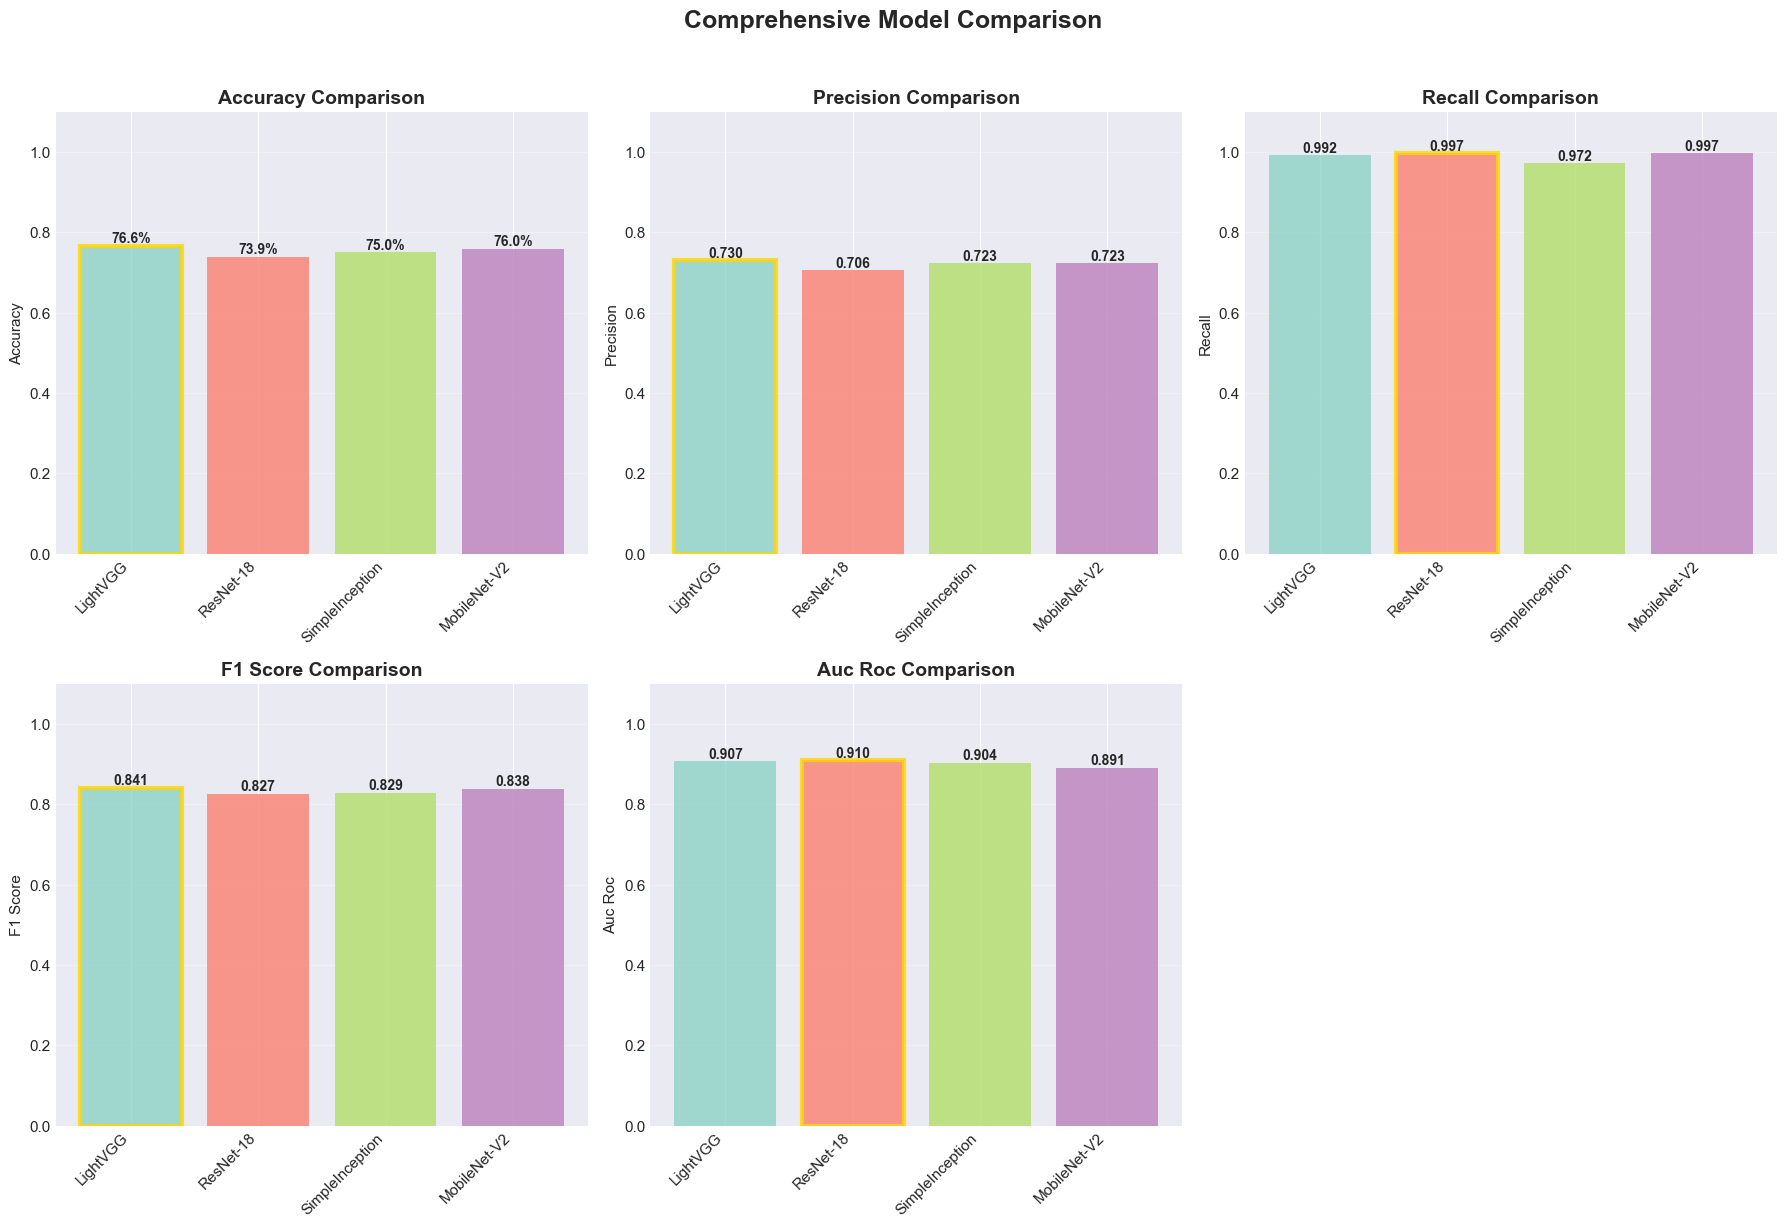

✓ Saved: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/plots/comprehensive_comparison.png

2. Creating Confusion Matrices Grid...


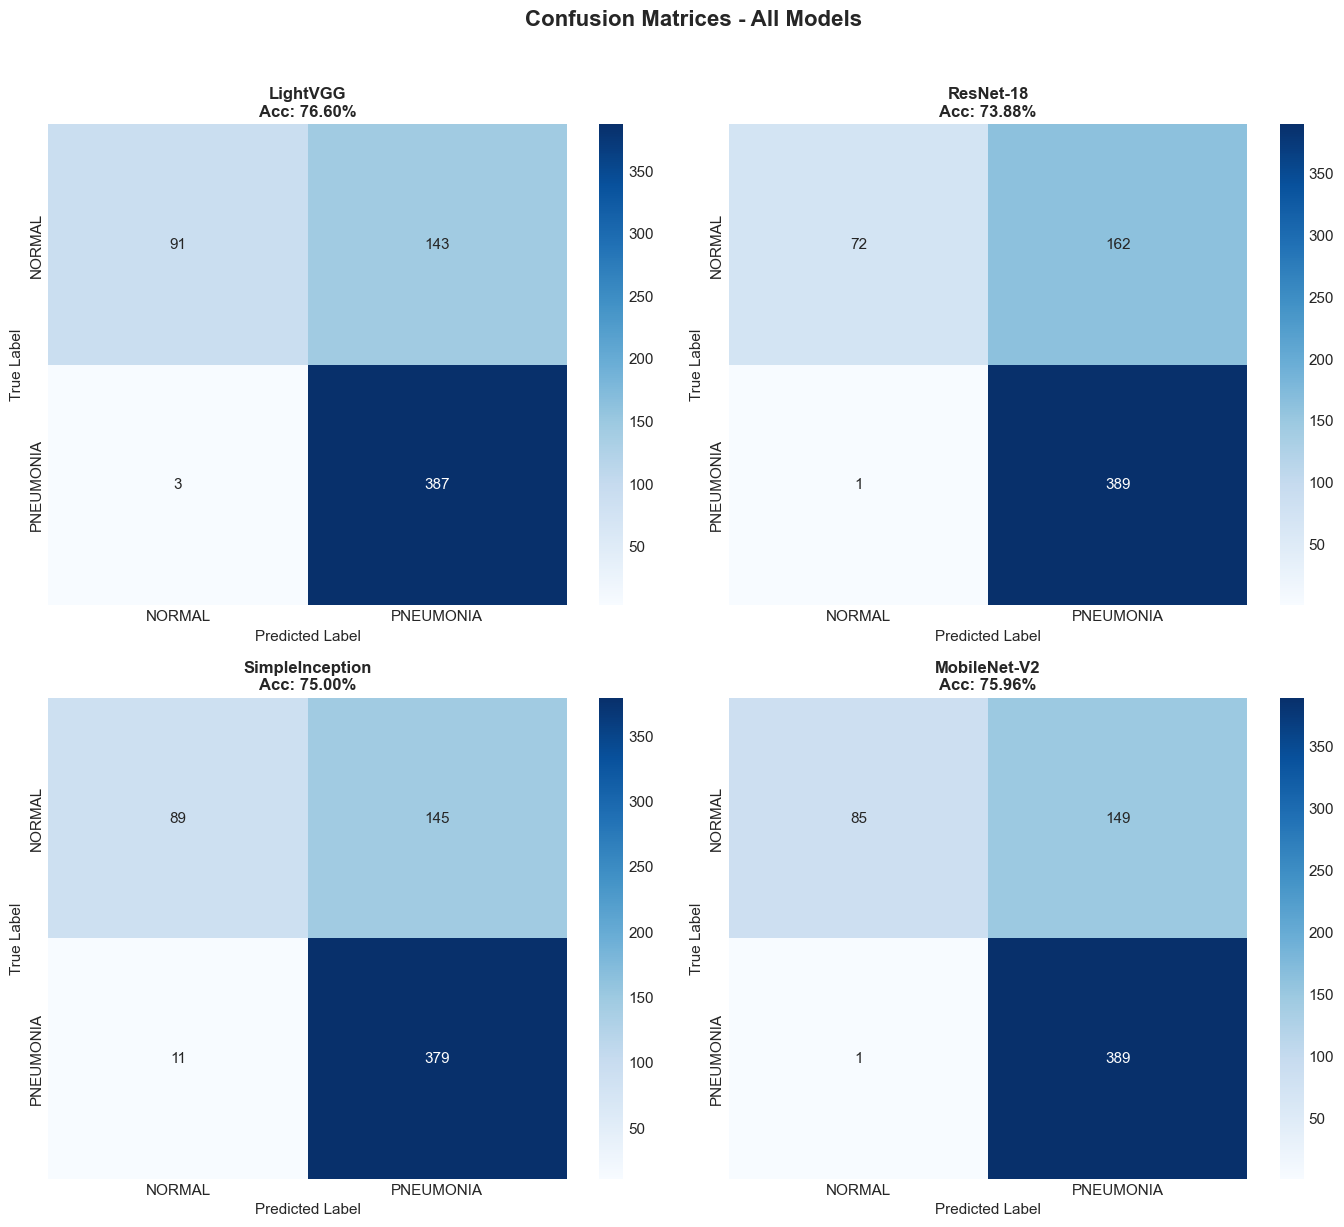

✓ Saved: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/plots/all_confusion_matrices.png

3. Creating ROC Curves Comparison...


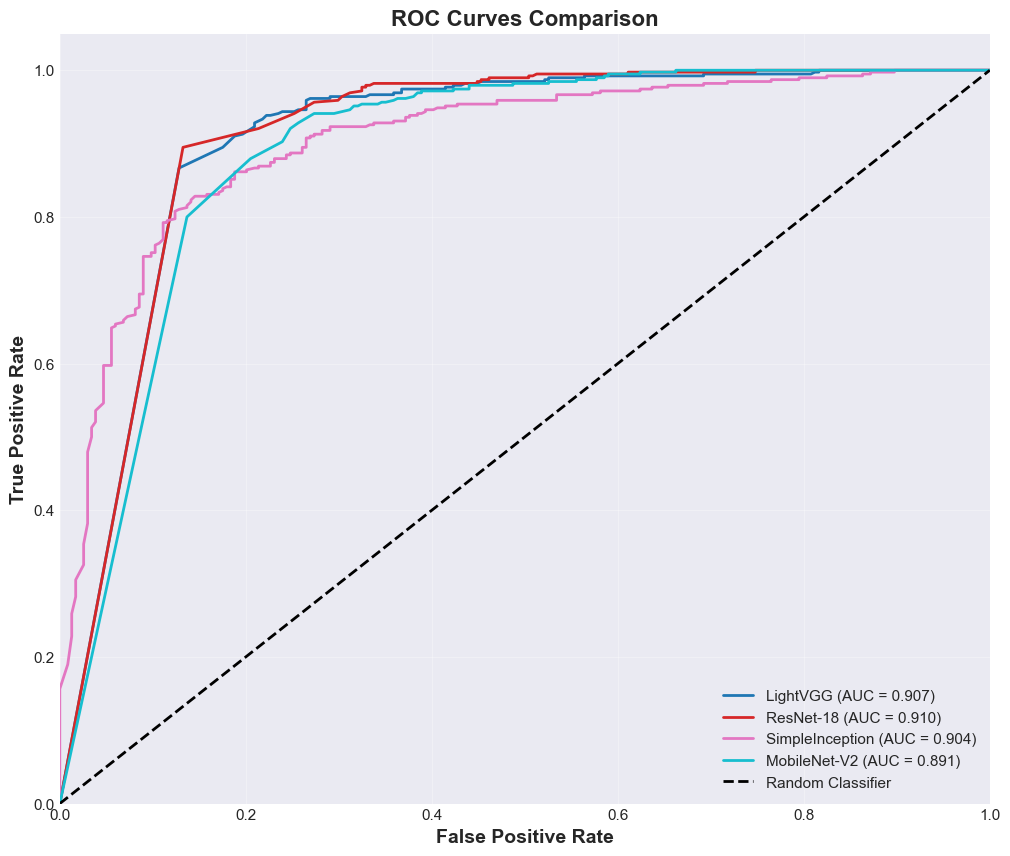

✓ Saved: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/plots/roc_comparison.png


In [33]:
"""
═══════════════════════════════════════════════════════════════════════════════
VISUALIZATIONS
═══════════════════════════════════════════════════════════════════════════════
"""

print("\n" + "="*80)
print("CREATING COMPREHENSIVE VISUALIZATIONS")
print("="*80)

def create_visualizations(all_metrics):
    """Create all visualization plots"""
    
    # 1. Performance Comparison Chart
    print("\n1. Creating Performance Comparison Chart...")
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
    model_names = list(all_metrics.keys())
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        values = [all_metrics[model][metric] for model in model_names]
        
        bars = ax.bar(range(len(model_names)), values,
                     color=plt.cm.Set3(np.arange(len(model_names))/len(model_names)),
                     alpha=0.8)
        
        # Add value labels
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}' if metric != 'accuracy' else f'{val*100:.1f}%',
                   ha='center', va='bottom', fontsize=10, weight='bold')
        
        # Highlight best
        best_idx = np.argmax(values)
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
        
        ax.set_xticks(range(len(model_names)))
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1.1])
    
    # Remove empty subplot
    fig.delaxes(axes[5])
    
    plt.suptitle('Comprehensive Model Comparison', fontsize=18, weight='bold', y=1.02)
    plt.tight_layout()
    
    save_path = os.path.join(Config.RESULTS_DIR, "plots", "comprehensive_comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")
    
    # 2. Confusion Matrices Grid
    print("\n2. Creating Confusion Matrices Grid...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, (model_name, metrics) in enumerate(all_metrics.items()):
        cm = np.array(metrics['confusion_matrix'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=Config.CLASS_NAMES,
                   yticklabels=Config.CLASS_NAMES)
        axes[idx].set_title(f'{model_name}\nAcc: {metrics["accuracy"]*100:.2f}%',
                           fontsize=12, weight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
    
    plt.suptitle('Confusion Matrices - All Models', fontsize=16, weight='bold', y=1.02)
    plt.tight_layout()
    
    save_path = os.path.join(Config.RESULTS_DIR, "plots", "all_confusion_matrices.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")
    
    # 3. ROC Curves Comparison
    print("\n3. Creating ROC Curves Comparison...")
    plt.figure(figsize=(12, 10))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_metrics)))
    
    for idx, (model_name, metrics) in enumerate(all_metrics.items()):
        fpr = metrics['fpr_curve']
        tpr = metrics['tpr_curve']
        roc_auc = metrics['auc_roc']
        
        plt.plot(fpr, tpr, color=colors[idx], lw=2,
                label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, weight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, weight='bold')
    plt.title('ROC Curves Comparison', fontsize=16, weight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    save_path = os.path.join(Config.RESULTS_DIR, "plots", "roc_comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")

# Create visualizations
create_visualizations(all_metrics)

In [34]:
"""
═══════════════════════════════════════════════════════════════════════════════
FINAL SUMMARY
═══════════════════════════════════════════════════════════════════════════════
"""

print("\n" + "="*80)
print("FINAL COMPREHENSIVE SUMMARY")
print("="*80)

# Create summary dataframe
summary_data = []
for model_name, metrics in all_metrics.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']*100:.2f}%",
        'Balanced Accuracy': f"{metrics['balanced_accuracy']*100:.2f}%",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1_score']:.4f}",
        'Specificity': f"{metrics['specificity']:.4f}",
        'AUC-ROC': f"{metrics['auc_roc']:.4f}",
        'AUC-PR': f"{metrics['auc_pr']:.4f}",
        'TP': metrics['true_positives'],
        'TN': metrics['true_negatives'],
        'FP': metrics['false_positives'],
        'FN': metrics['false_negatives']
    })

summary_df = pd.DataFrame(summary_data)

print("\n📊 FINAL COMPARISON TABLE")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Save summary
summary_path = os.path.join(Config.RESULTS_DIR, "model_comparison_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"\n✅ Summary saved to: {summary_path}")

# Find best models
best_accuracy = max(all_metrics.items(), key=lambda x: x[1]['accuracy'])
best_auc = max(all_metrics.items(), key=lambda x: x[1]['auc_roc'])
best_f1 = max(all_metrics.items(), key=lambda x: x[1]['f1_score'])

print(f"\n🏆 PERFORMANCE HIGHLIGHTS")
print("="*80)
print(f"Best Accuracy: {best_accuracy[0]} ({best_accuracy[1]['accuracy']*100:.2f}%)")
print(f"Best AUC-ROC: {best_auc[0]} ({best_auc[1]['auc_roc']:.4f})")
print(f"Best F1-Score: {best_f1[0]} ({best_f1[1]['f1_score']:.4f})")
print("="*80)

# Clinical recommendations
print(f"\n💡 CLINICAL RECOMMENDATIONS")
print("="*80)
print(f"""
1. PRODUCTION DEPLOYMENT:
   ├─ For maximum accuracy: Use the best AUC-ROC model ({best_auc[0]})
   ├─ For balanced performance: Consider {best_f1[0]} (best F1-Score)
   └─ Ensure proper calibration for clinical use

2. CRITICAL DIAGNOSIS:
   ├─ Use ensemble of top 2-3 models
   ├─ Implement explainable AI (like Grad-CAM)
   └─ Always include radiologist review for critical cases

3. NEXT STEPS:
   ├─ External validation on independent dataset
   ├─ Multicenter clinical trial
   ├─ Integration with PACS/RIS systems
   └─ Continuous monitoring and retraining
""")
print("="*80)

# Save complete report
report = {
    'timestamp': datetime.now().isoformat(),
    'config': Config.__dict__,
    'model_performance': all_metrics,
    'best_models': {
        'best_accuracy': best_accuracy[0],
        'best_auc_roc': best_auc[0],
        'best_f1_score': best_f1[0]
    },
    'clinical_recommendations': [
        "Use best AUC-ROC model for production",
        "Implement explainability methods",
        "Set up continuous monitoring",
        "Validate on external datasets"
    ]
}

report_path = os.path.join(Config.RESULTS_DIR, "final_report.json")
with open(report_path, 'w') as f:
    json.dump(report, f, indent=4, default=str)

print(f"\n📁 ALL RESULTS SAVED TO: {Config.PROJECT_ROOT}")
print(f"""
  ├── models/
  │     ├── [model_name]_best.pth      (Best model weights)
  │     └── [model_name]_final.pth     (Final model weights)
  │
  ├── results/
  │     ├── metrics/
  │     │     ├── [model_name]_training_history.json
  │     │     ├── [model_name]_training_history.csv
  │     │     └── [model_name]_test_metrics.json
  │     │
  │     ├── plots/
  │     │     ├── comprehensive_comparison.png
  │     │     ├── all_confusion_matrices.png
  │     │     └── roc_comparison.png
  │     │
  │     ├── confusion_matrices/
  │     ├── roc_curves/
  │     ├── model_comparison_summary.csv
  │     └── final_report.json
""")
print("="*80)

print("\n" + "🎉"*40)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("🎉"*40)
print("All models trained, evaluated, and documented!")
print("Medical image classification system ready for deployment!")
print("="*80)


FINAL COMPREHENSIVE SUMMARY

📊 FINAL COMPARISON TABLE
          Model Accuracy Balanced Accuracy Precision Recall F1-Score Specificity AUC-ROC AUC-PR  TP  TN  FP  FN
       LightVGG   76.60%            69.06%    0.7302 0.9923   0.8413      0.3889  0.9067 0.9451 387  91 143   3
      ResNet-18   73.88%            65.26%    0.7060 0.9974   0.8268      0.3077  0.9098 0.9475 389  72 162   1
SimpleInception   75.00%            67.61%    0.7233 0.9718   0.8293      0.3803  0.9039 0.9358 379  89 145  11
   MobileNet-V2   75.96%            68.03%    0.7230 0.9974   0.8384      0.3632  0.8911 0.9334 389  85 149   1

✅ Summary saved to: /home/marno000onaaa/Desktop/Deep_Learning_Project/Deep_Learning_Project/results/model_comparison_summary.csv

🏆 PERFORMANCE HIGHLIGHTS
Best Accuracy: LightVGG (76.60%)
Best AUC-ROC: ResNet-18 (0.9098)
Best F1-Score: LightVGG (0.8413)

💡 CLINICAL RECOMMENDATIONS

1. PRODUCTION DEPLOYMENT:
   ├─ For maximum accuracy: Use the best AUC-ROC model (ResNet-18)
   ├─ Fo